# Time Transformer [`t2`]

Time Transformer is an attempt to apply the transformer architecture to time series. In this walk through I will use the **WISDM** (**WI**reless **S**ensor **D**ata **M**ining dataset: http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf)
    

The purpose of this dataset is for multivariate time series classification, which is exactly the problem we are trying to solve for Type Ia Supernova. With Supernova classification we have observations accross 6 passbands for "each timestep". 

There is a disclaimer is since we don't _actually_ have measurements for all 6 'variables' for everytime step, but this is resolved with a Gaussian Process regression for interpoloation of points between actual observed data.

Therefore we will use this dataset as a proof on concept to see if this type of architecture would be suitable for our problem too.

#### TODO

    1. Implement a custom callback
    2. Compare LSTM of blog post
    3. Put code into t2 files
    4. Explain dimensions, give examples. Windowing etc. use TF time_series.ipynb notebooks as example
    5. Walk through what is heppening

## The Data

First let's inspect the data!

### Download the WISM dataset

In [1]:
# !gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
# !tar -xvf WISDM_ar_latest.tar.gz

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [8]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('../data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

As mentioned in the [WISDM website](http://www.cis.fordham.edu/wisdm/dataset.php) the dataset can be describes as follows:
    
**Raw Time Series Data**
- Number of examples: 1,098,207
- Number of attributes: 6
- Missing attribute values: None

**Class Distribution**
- Walking: 424,400 (38.6%)
- Jogging: 342,177 (31.2%)
- Upstairs: 122,869 (11.2%)
- Downstairs: 100,427 (9.1%)
- Sitting: 59,939 (5.5%)
- Standing: 48,395 (4.4%)

This can visualised below:

In [9]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [10]:
df.shape

(1098203, 6)

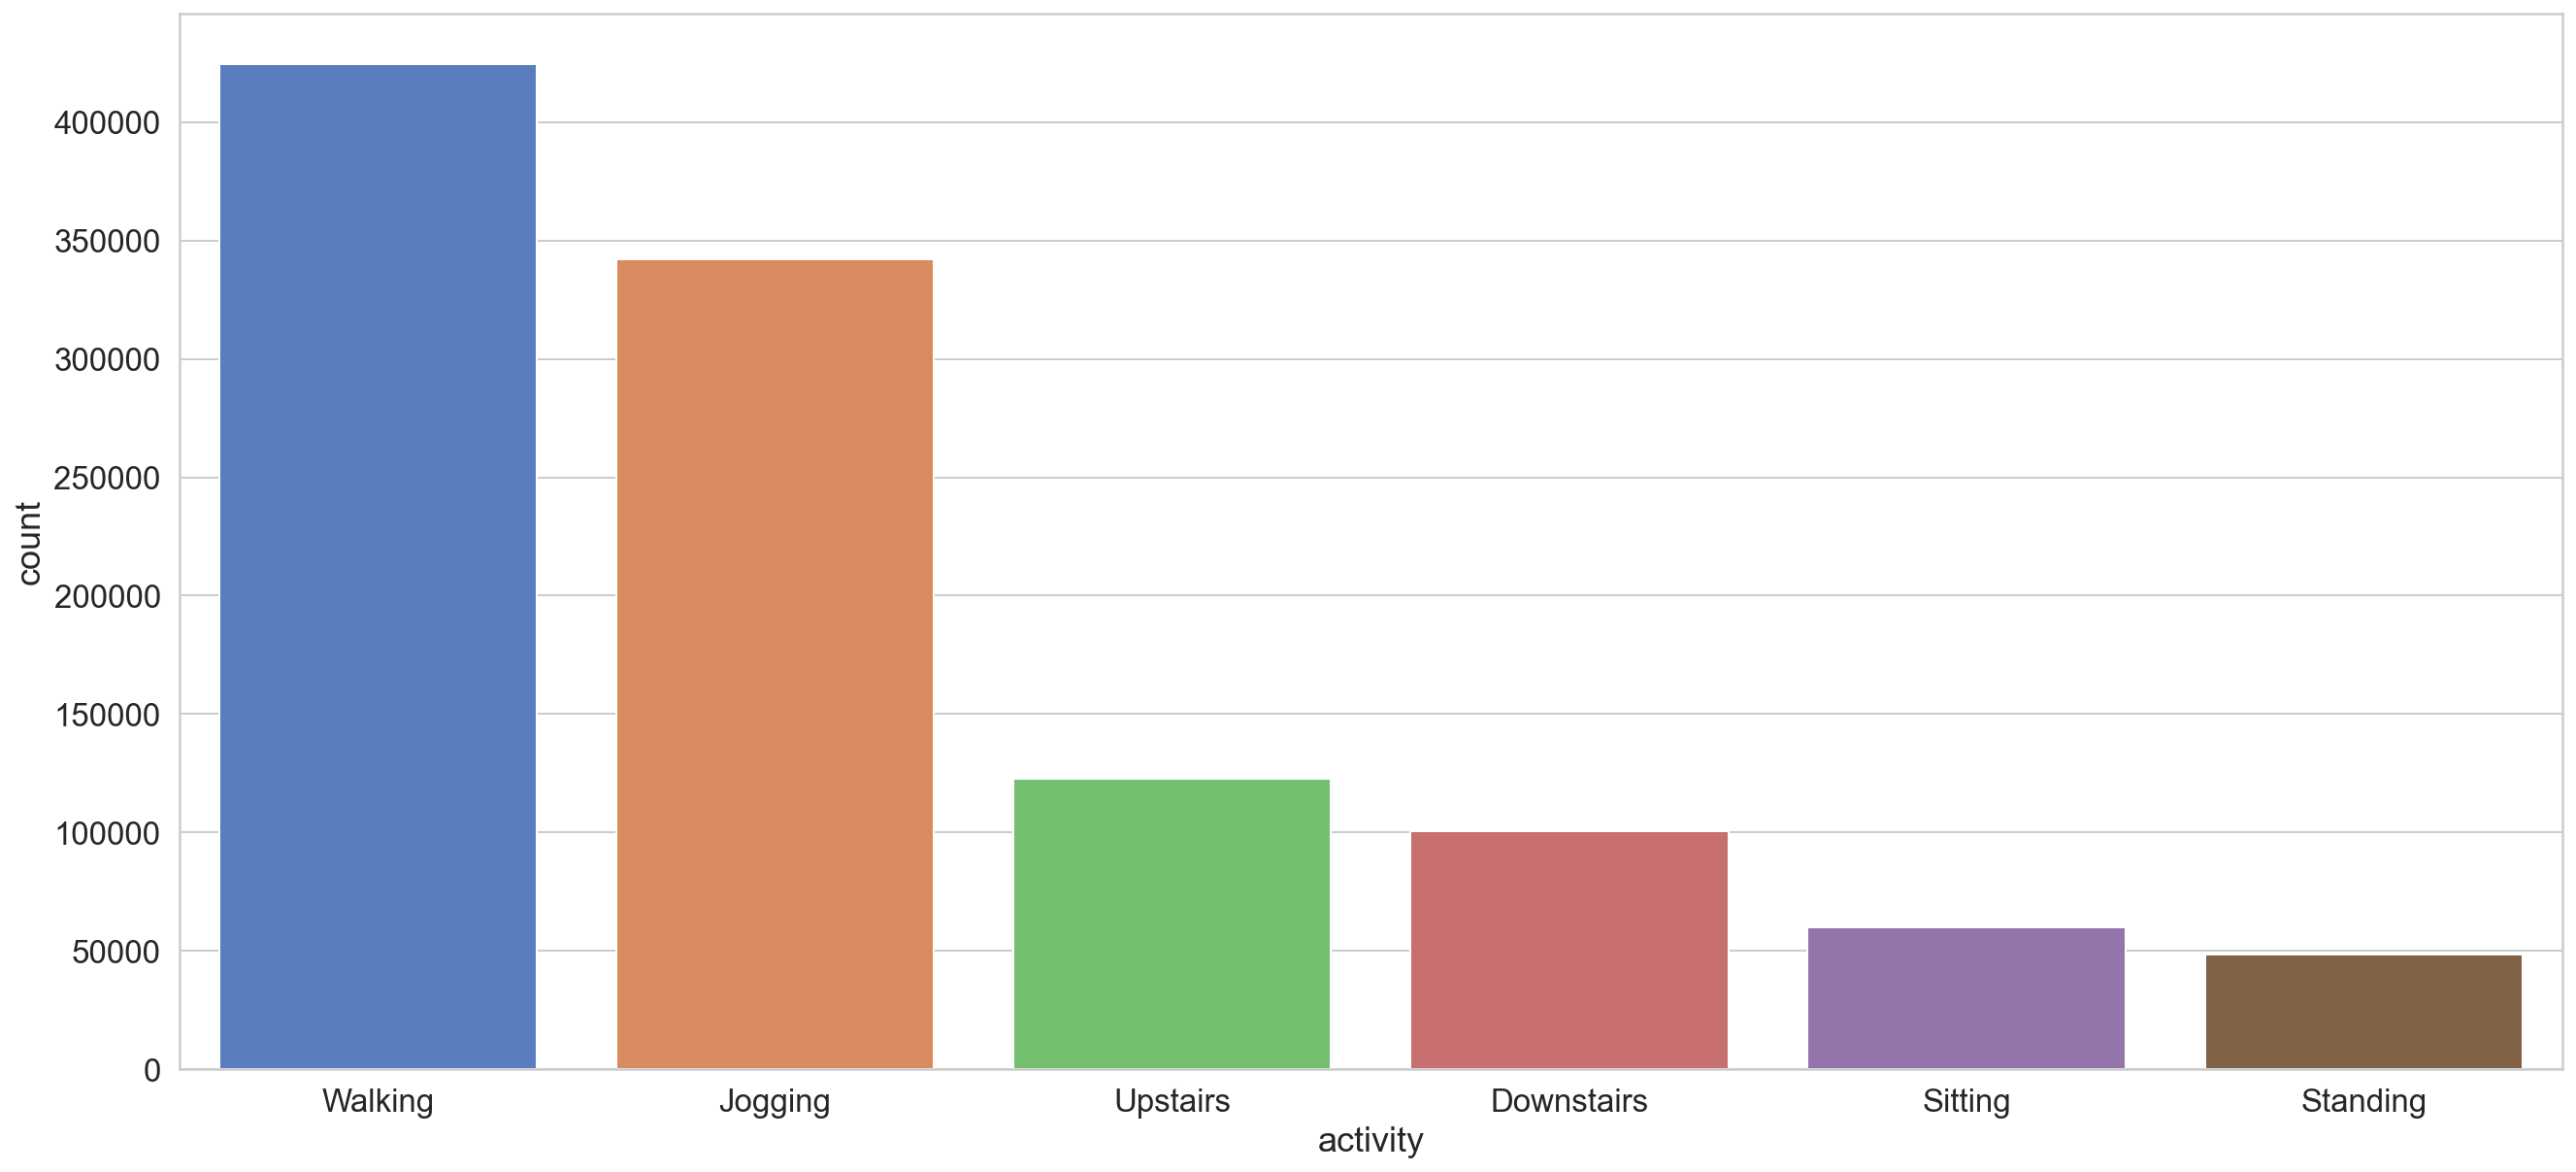

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

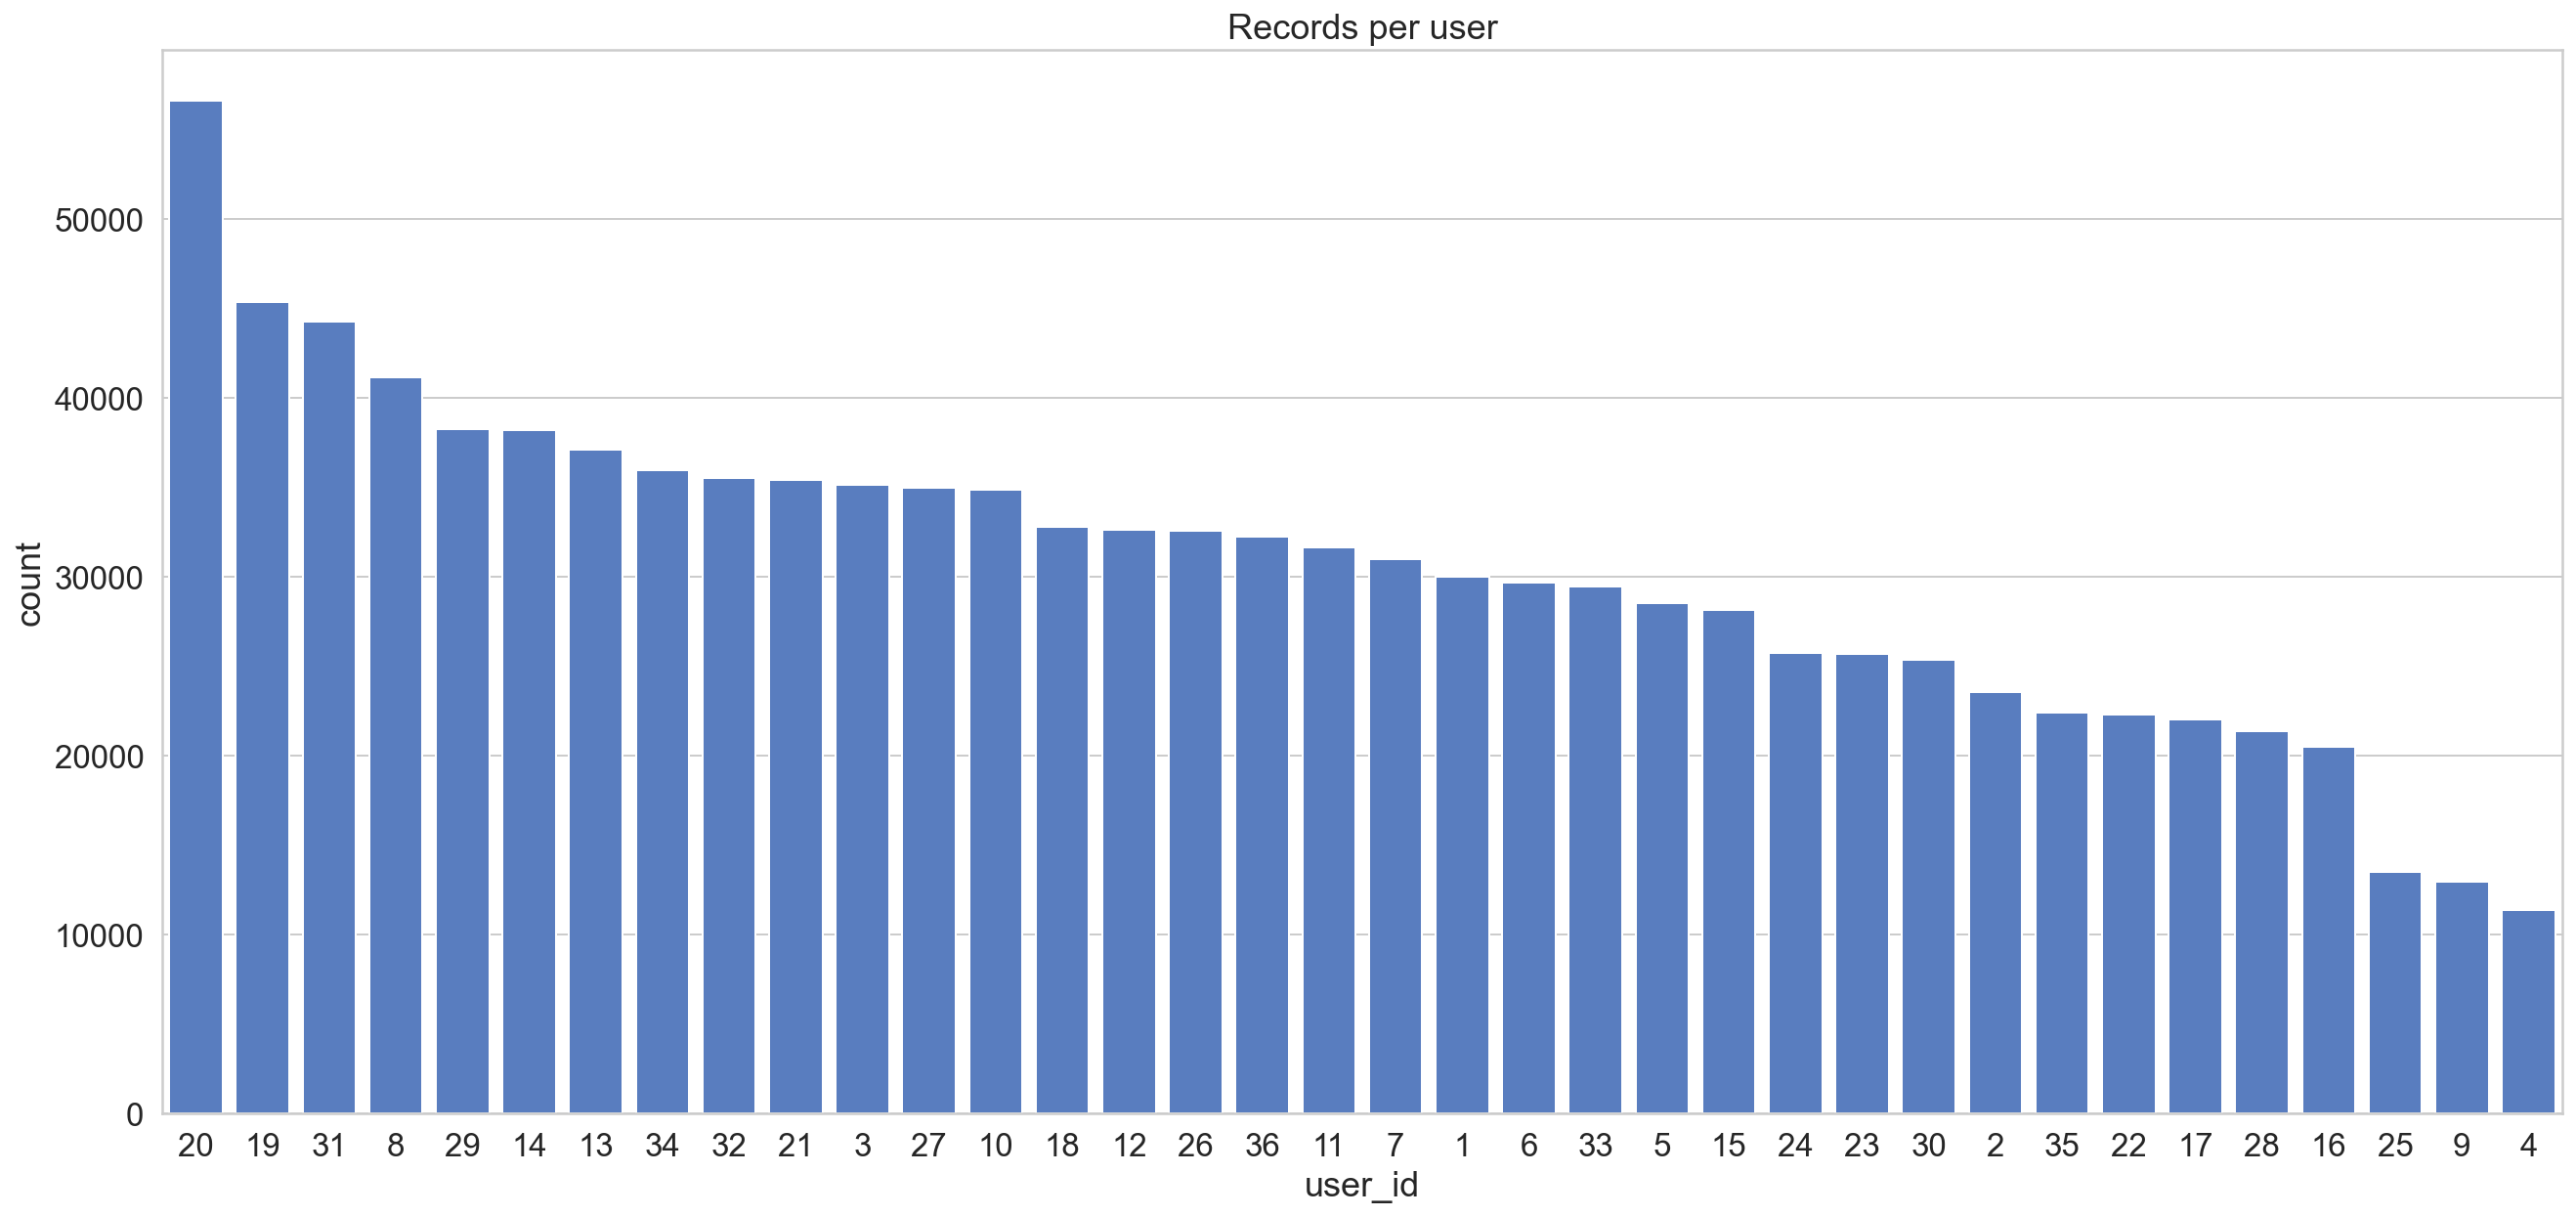

In [12]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

Inspecting the time series data...

In [13]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:400]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

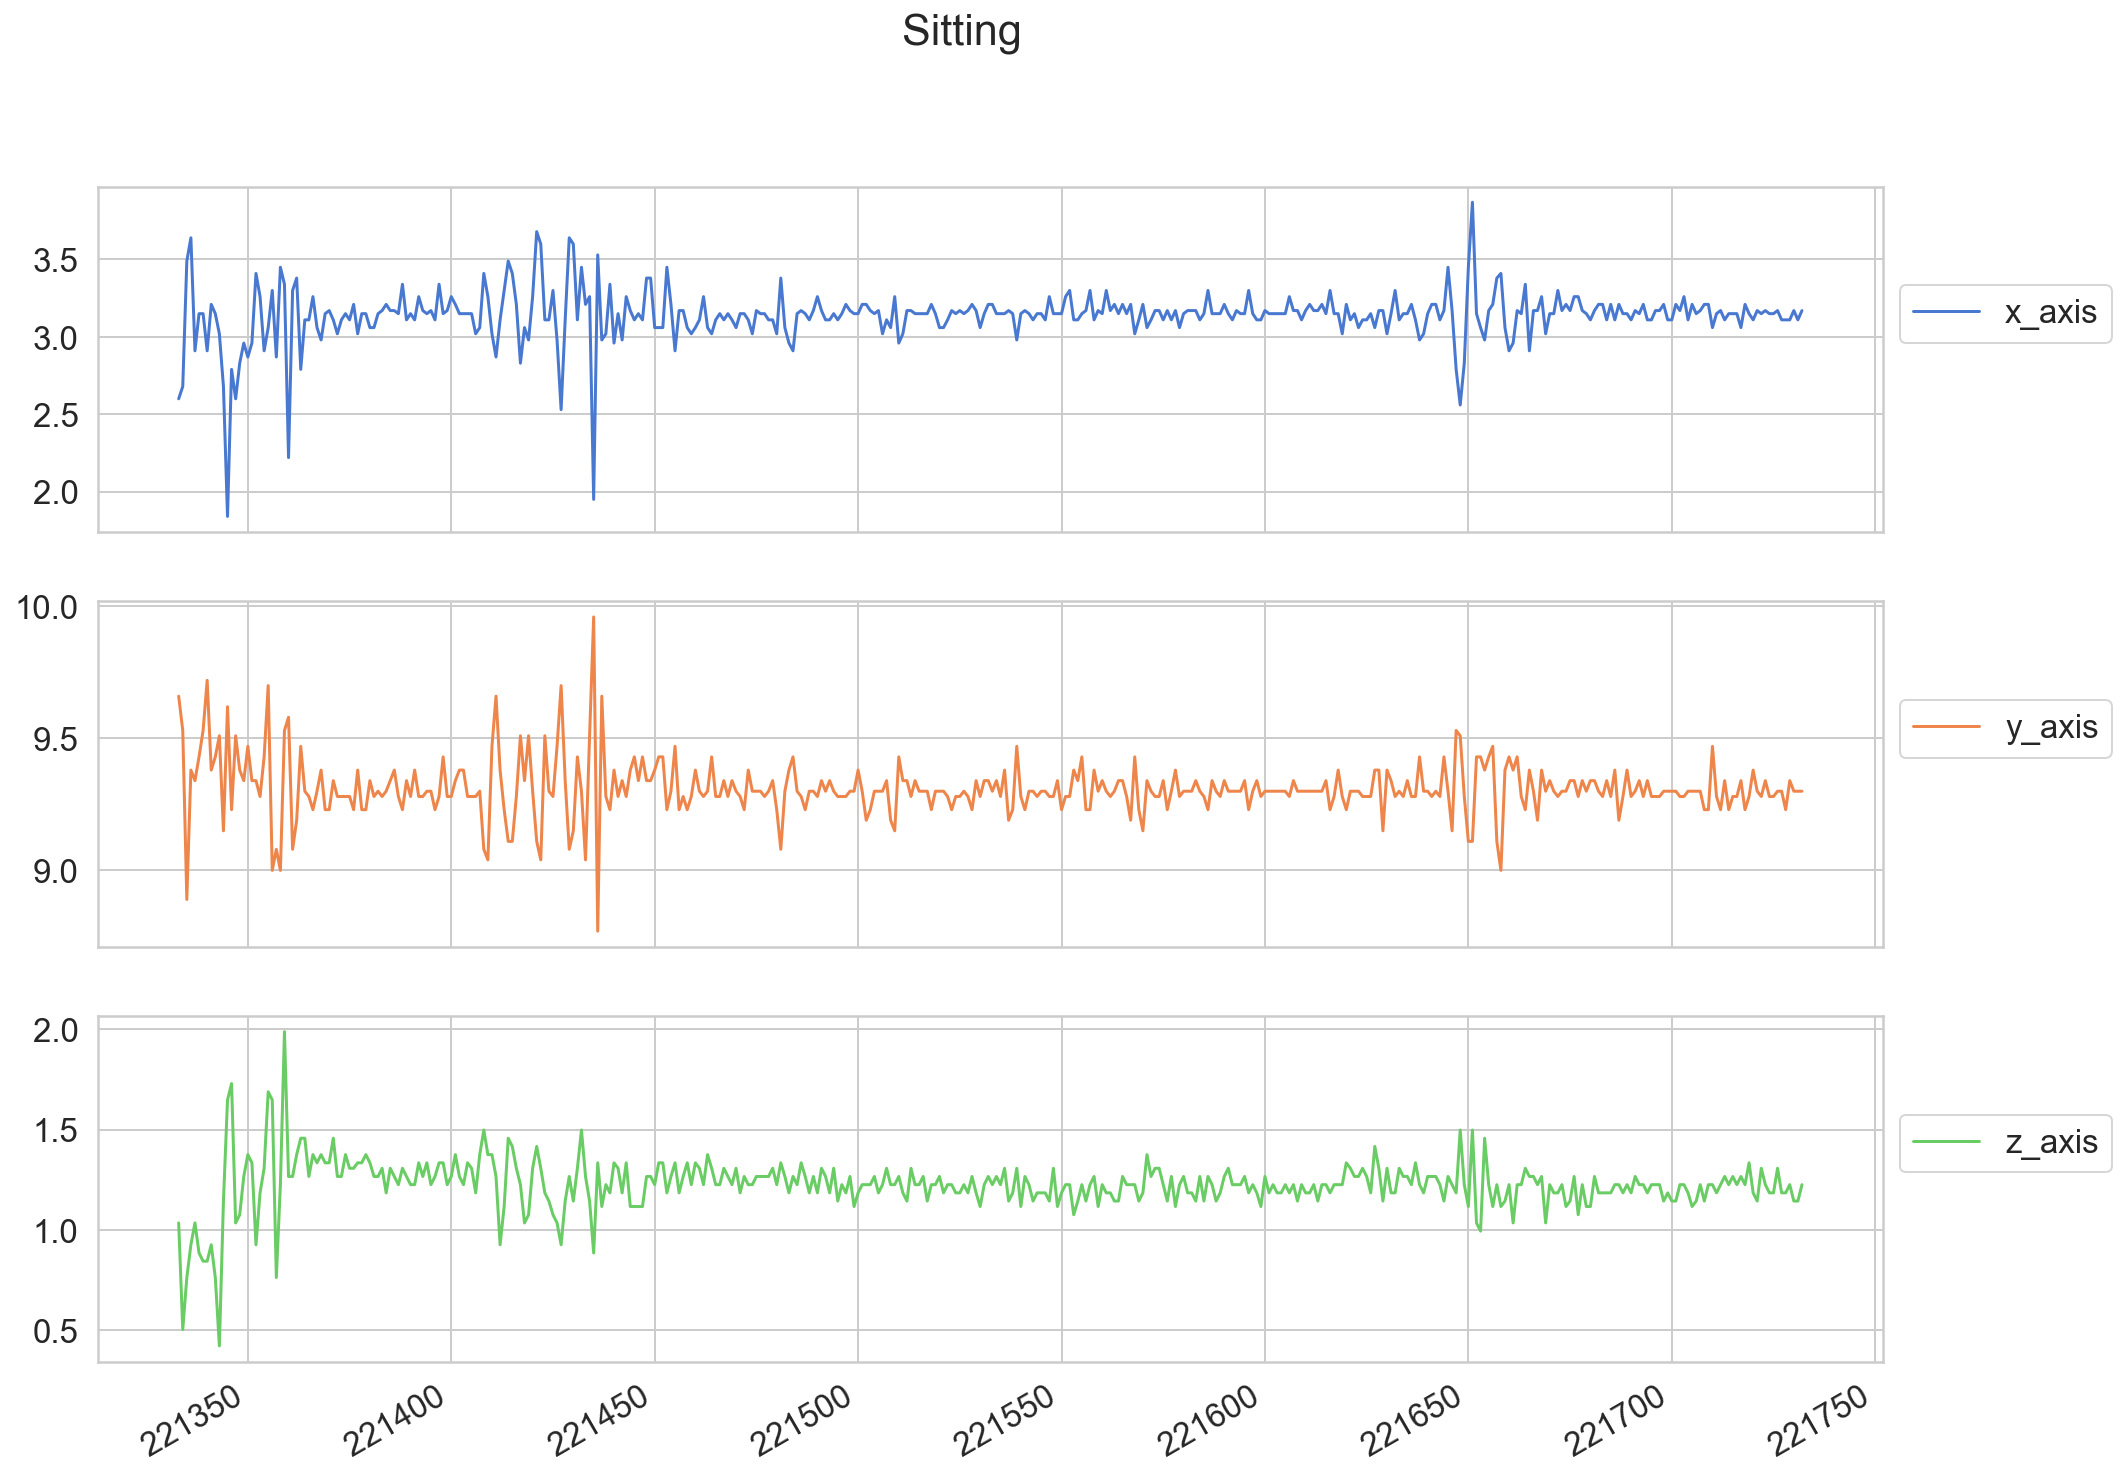

In [14]:
plot_activity("Sitting", df);

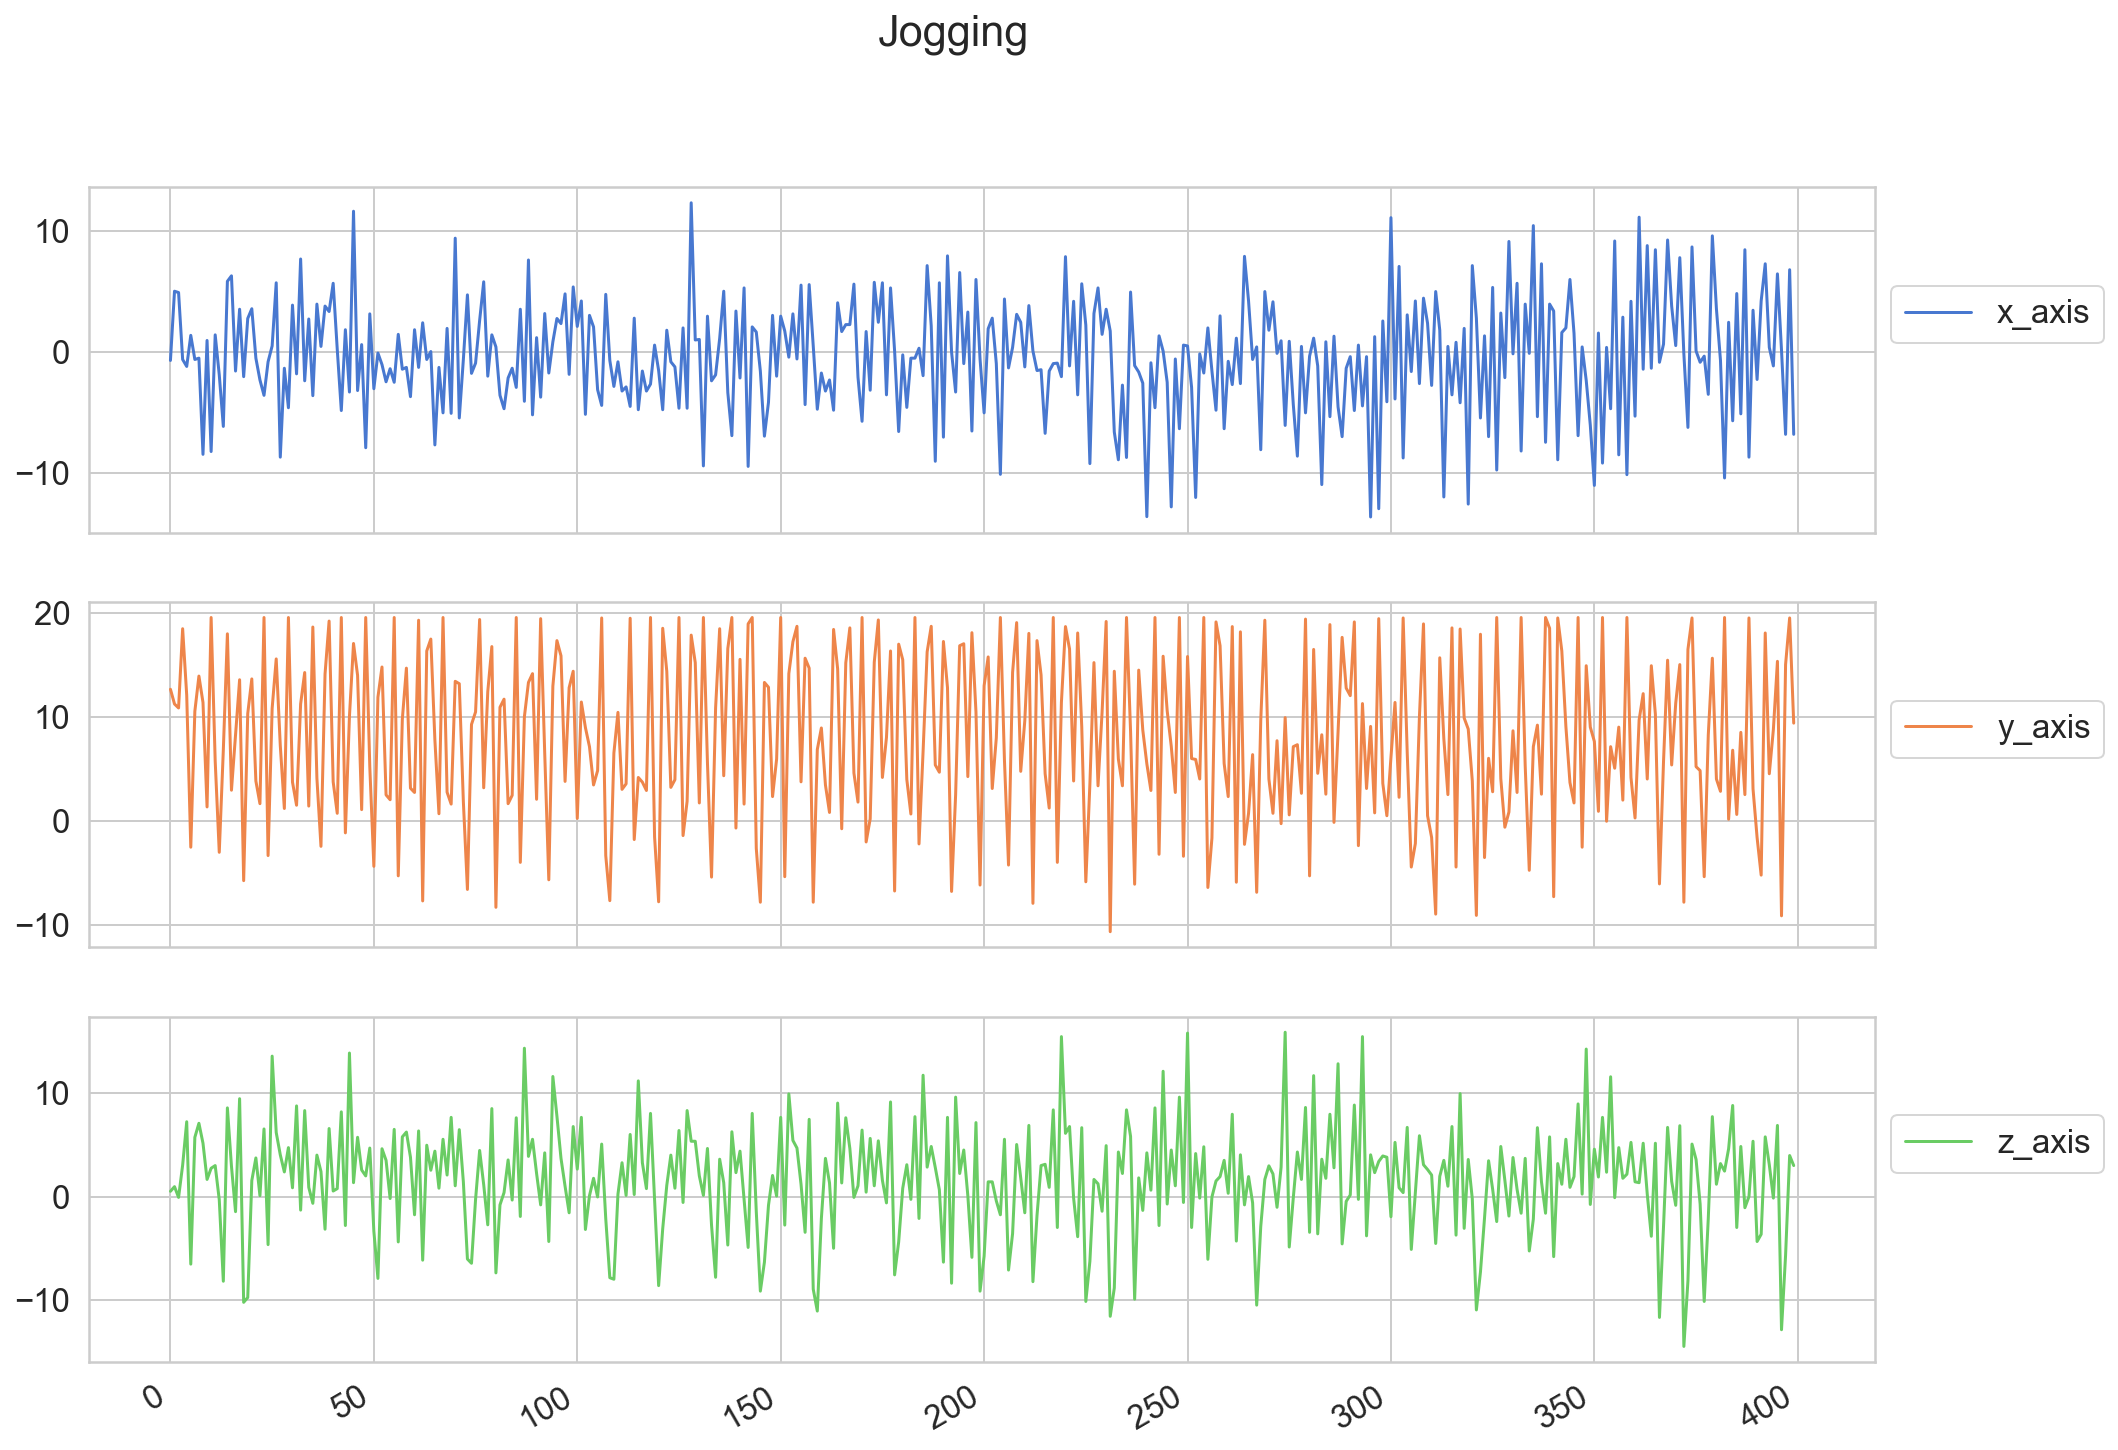

In [15]:
plot_activity("Jogging", df);

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

In order to work with this data, we will need to do some pre-processing such that all axis are scaled correctly.

Furthermore there is another bit of "pre-processing" required such that we can use `keras` library for Deep Learning and classification. We need to split our dataset into a _train_ and _test_ (_validation_) set and we will need to **one-hot** encode our targets.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets. With time-series data, it is very important not to allow for data to overlap from train to test, i.e we want to avoid the dreaded data leakage problem.

For this we shall first split the data into a train/test set, and _then_ apply a windowing function to create small time segments we can then use for training and testing

In [16]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [17]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [18]:
df_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.019955,0.252293,-0.090959
8490,17,Walking,57870012316000,-0.055118,0.297966,-0.099228
8491,17,Walking,57870122301000,-0.085505,0.257187,-0.124035
8492,17,Walking,57870222246000,-0.035456,0.284917,-0.085446
8493,17,Walking,57870332292000,-0.035456,0.293073,-0.107497


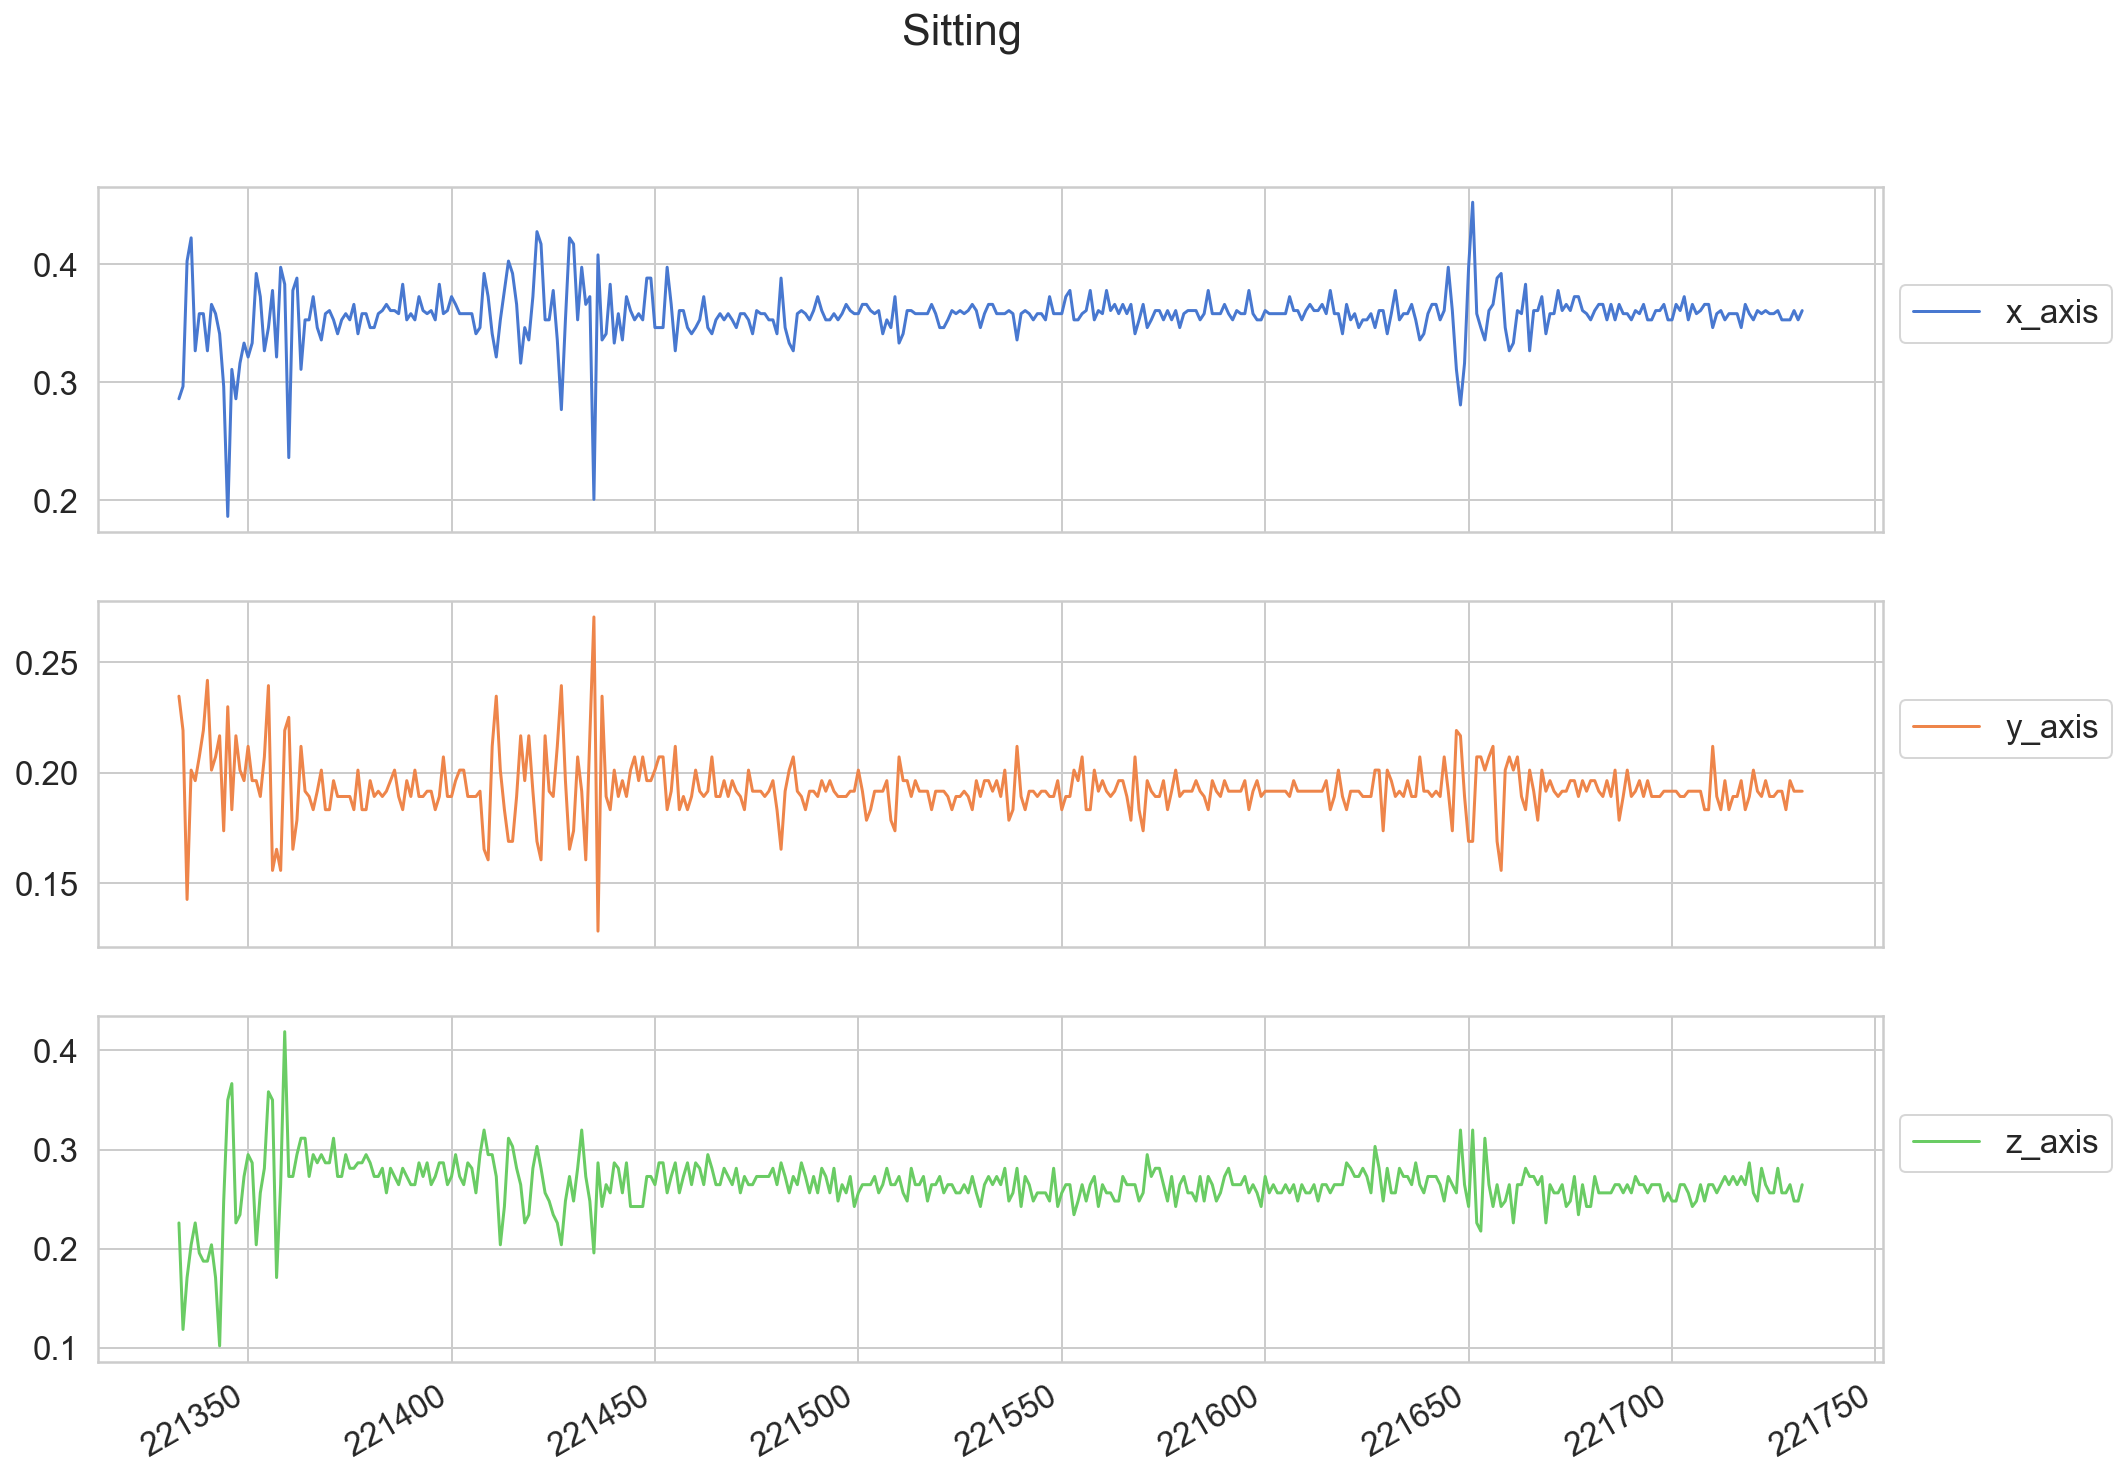

In [19]:
plot_activity("Sitting", df_train);

In [20]:
# column_indices = {name: i for i, name in enumerate(df.columns)}

# n = len(df)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]

# num_features = df.shape[1]
# num_features

In [21]:
# train_df[['x_axis', 'y_axis', 'z_axis']].head()

In [22]:
df_train[['x_axis', 'y_axis', 'z_axis']].keys()

Index(['x_axis', 'y_axis', 'z_axis'], dtype='object')

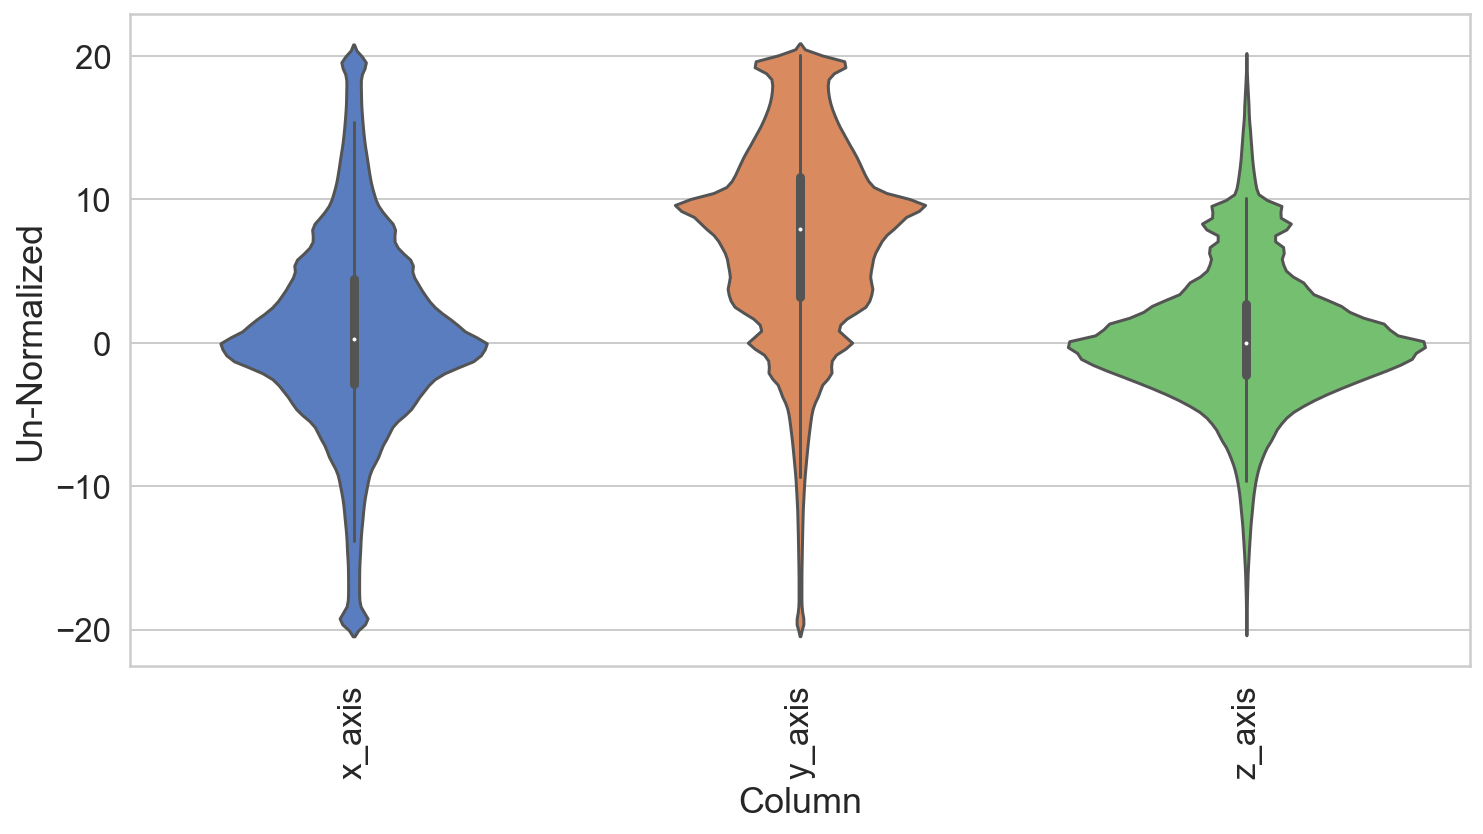

In [23]:
df_dist = df[['x_axis', 'y_axis', 'z_axis']].melt(var_name='Column', value_name='Un-Normalized')

df_dist.dropna(inplace=True)
df_dist = df_dist.astype({'Un-Normalized': 'float'})

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Un-Normalized', data=df_dist)
_ = ax.set_xticklabels(df_train[['x_axis', 'y_axis', 'z_axis']].keys(), rotation=90)

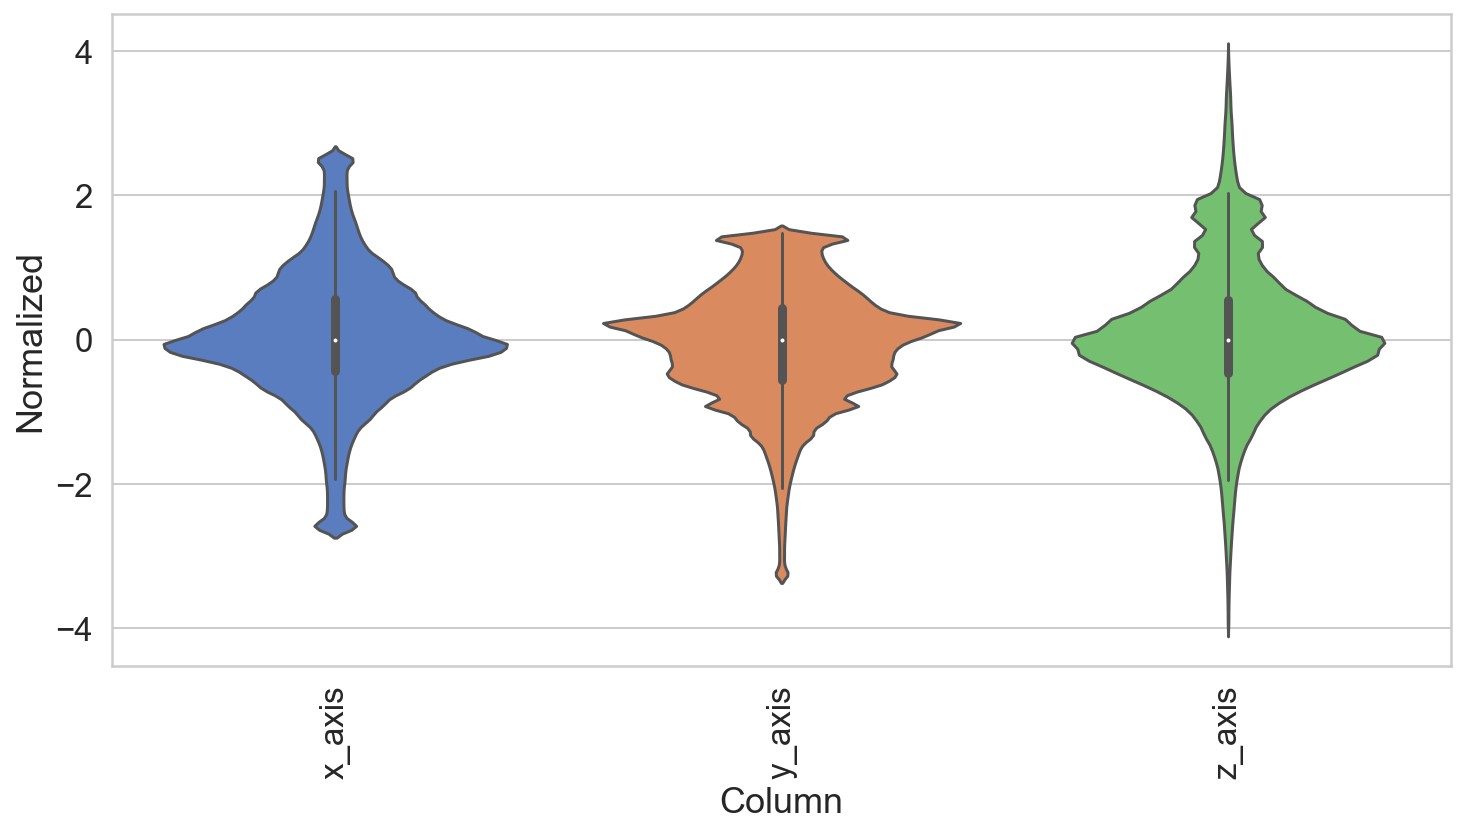

In [24]:
df_norm = df_train[['x_axis', 'y_axis', 'z_axis']].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_norm)
_ = ax.set_xticklabels(df_train[['x_axis', 'y_axis', 'z_axis']].keys(), rotation=90)

Much better! Now let's apply the windowing function...

In [25]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [26]:
print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 1)


And finally, one-hot encoding...

In [27]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [28]:
print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 6)


What we have now is a dataset of the shape above: (22454, 200, 3) (22454, 6) for `X_train` and `y_train` respectivly. 

This is to say we have 22452 _batches_, that are 200 time-step windows, that contain 3 variables each, i.e. `x, y, z` measurements. As you may have guess alreeady, this could be translated to X-number of _batches_, that are X-*MJD* day length windows, each containing 6 pass-band filter measurements.

## What is the Transformer achitecture?

The overall architecture of the Transformer network can be seen below. It consists of the _encoder_ section and a _decoder_ section

<img src="images/transformer-arch.png" height=40% width=40%>

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Implement multi head self attention as a Keras layer

In [30]:
# This has been pulled verbatim from the Keras documatation page: 
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [31]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [32]:
embed_dim = 128  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

## Adapting the Transformer for Time-Series

The Transformer architeecture was originally applied to NLP tasks of translation. For this, there were specific stages in the pipeline that are focused towards working with words. For example, the embedding layer would project each word into a high-dimensional vector space followed by a positional enciding layer to ensure sequential information is preversed.

In the case of time-series, a simple Dese layer can be used to map the (`m, T, 6`)(batch, time-steps, features) into a (`m, 128`)(batch, time-steps*features) 

### Build the model

In [33]:
model = keras.Sequential()

#model.add(layers.Dense(units=128))
model.add(layers.Convolution1D(filters=128, kernel_size=16, activation='relu'))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(6, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [34]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test)
)

Epoch 1/10
702/702 [==============================] - 145s 207ms/step - loss: 0.3571 - acc: 0.8714 - val_loss: 0.2970 - val_acc: 0.9227
Epoch 2/10
702/702 [==============================] - 158s 225ms/step - loss: 0.1257 - acc: 0.9596 - val_loss: 0.4579 - val_acc: 0.8716
Epoch 3/10
702/702 [==============================] - 152s 217ms/step - loss: 0.0858 - acc: 0.9747 - val_loss: 0.3344 - val_acc: 0.9175
Epoch 4/10
702/702 [==============================] - 161s 230ms/step - loss: 0.0658 - acc: 0.9793 - val_loss: 0.3944 - val_acc: 0.9004
Epoch 5/10
702/702 [==============================] - 163s 233ms/step - loss: 0.0584 - acc: 0.9820 - val_loss: 0.3425 - val_acc: 0.9317
Epoch 6/10
702/702 [==============================] - 171s 243ms/step - loss: 0.0479 - acc: 0.9854 - val_loss: 0.3121 - val_acc: 0.9433
Epoch 7/10
702/702 [==============================] - 183s 261ms/step - loss: 0.0444 - acc: 0.9858 - val_loss: 0.4429 - val_acc: 0.9109
Epoch 8/10
702/702 [============================

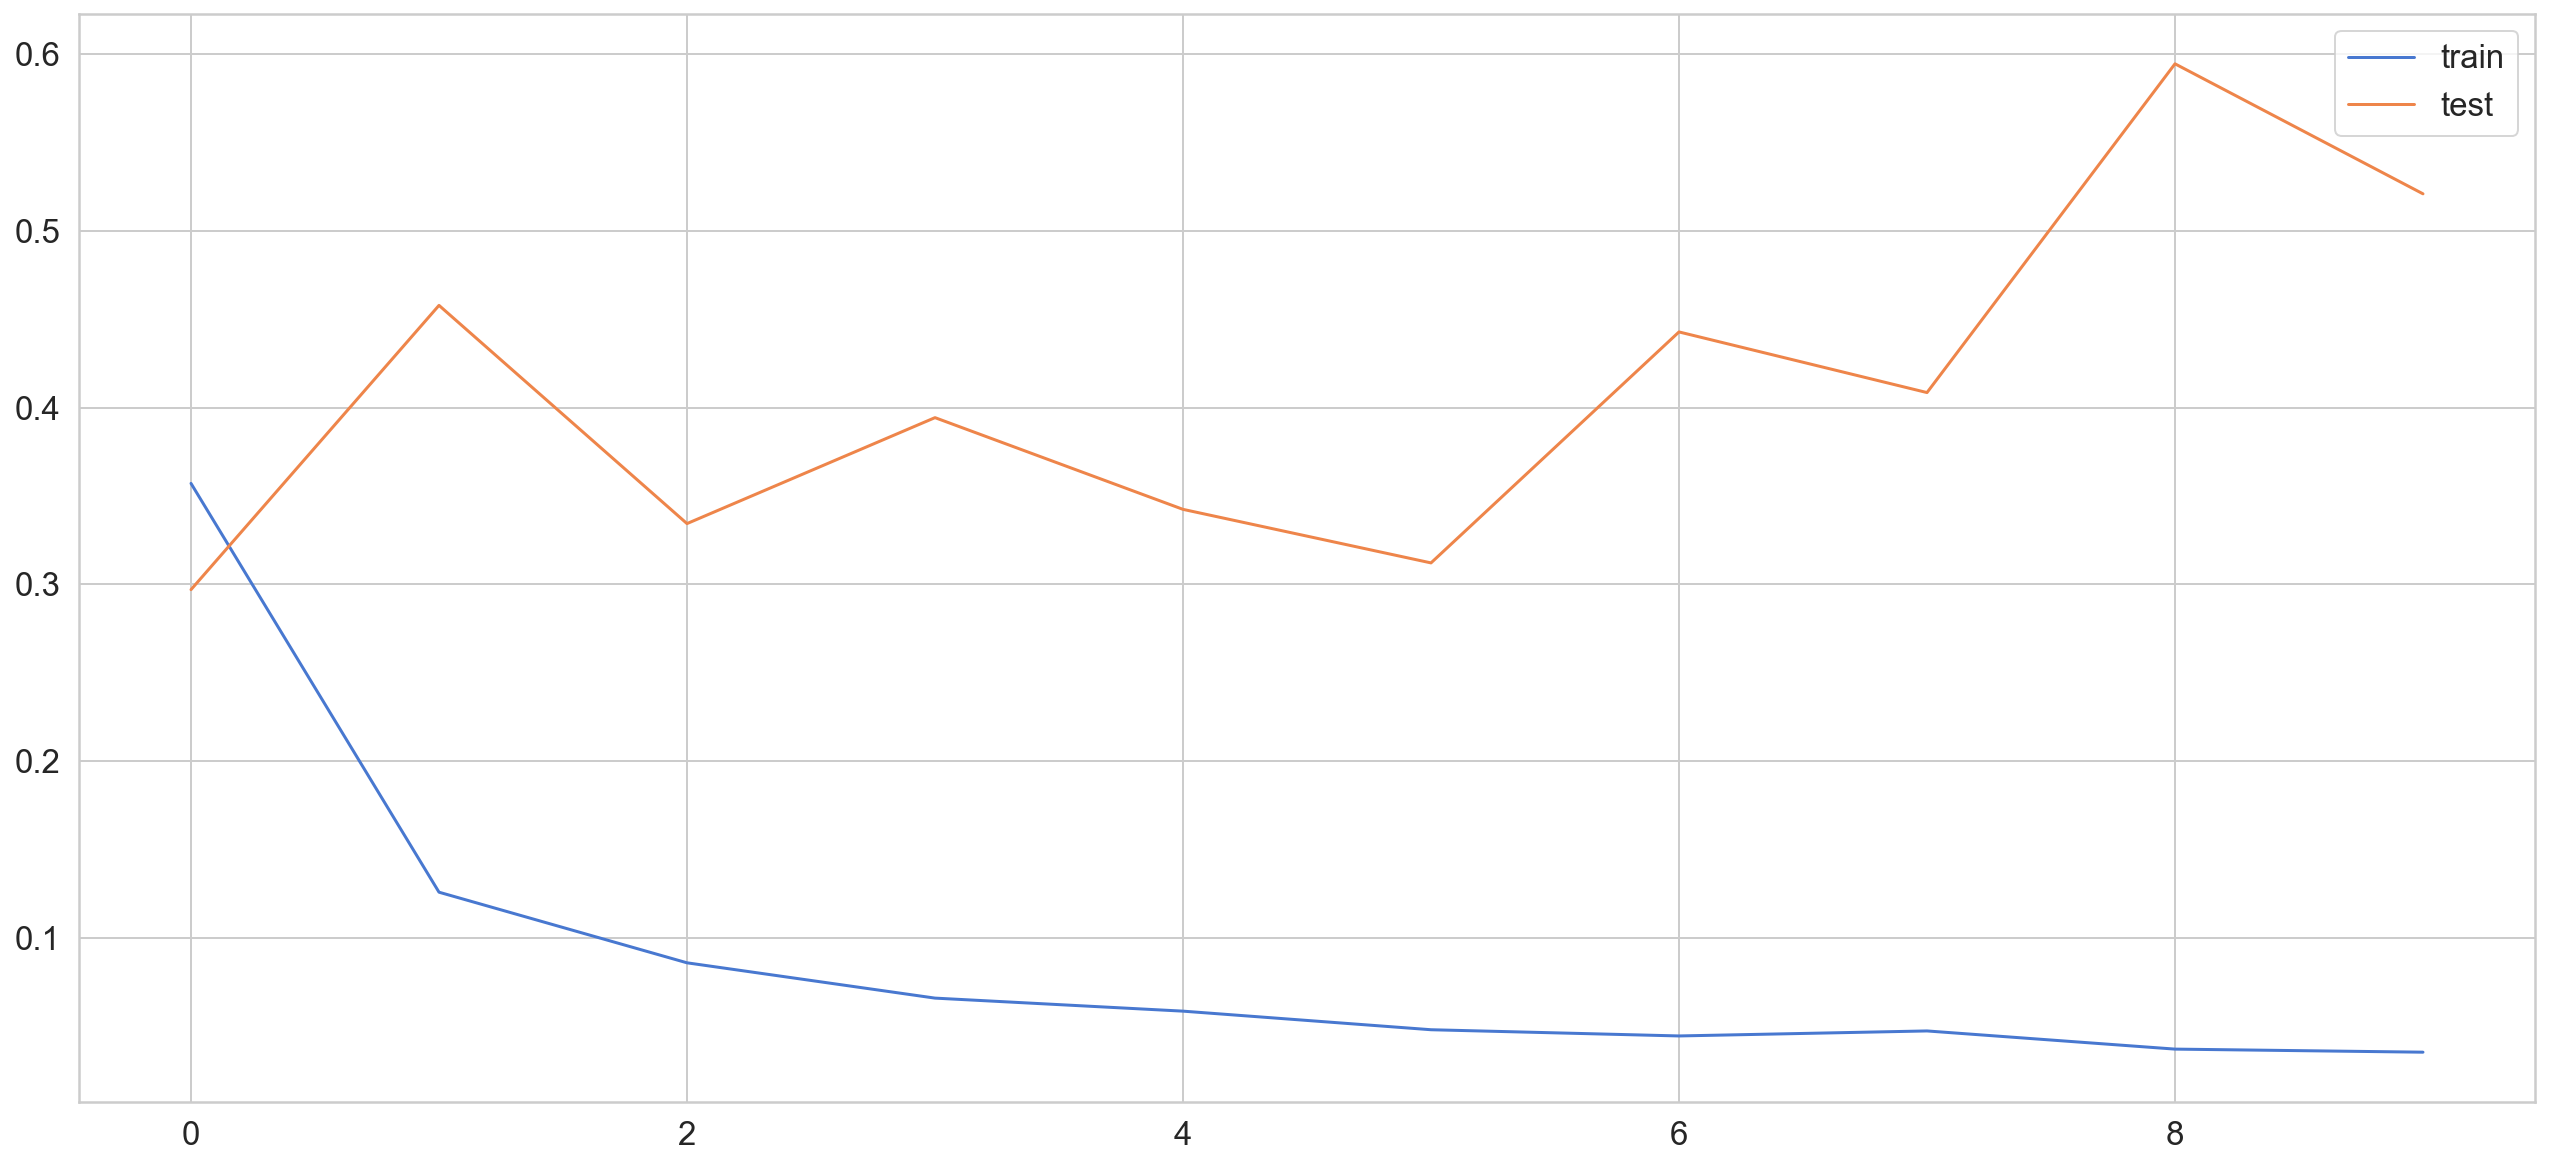

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

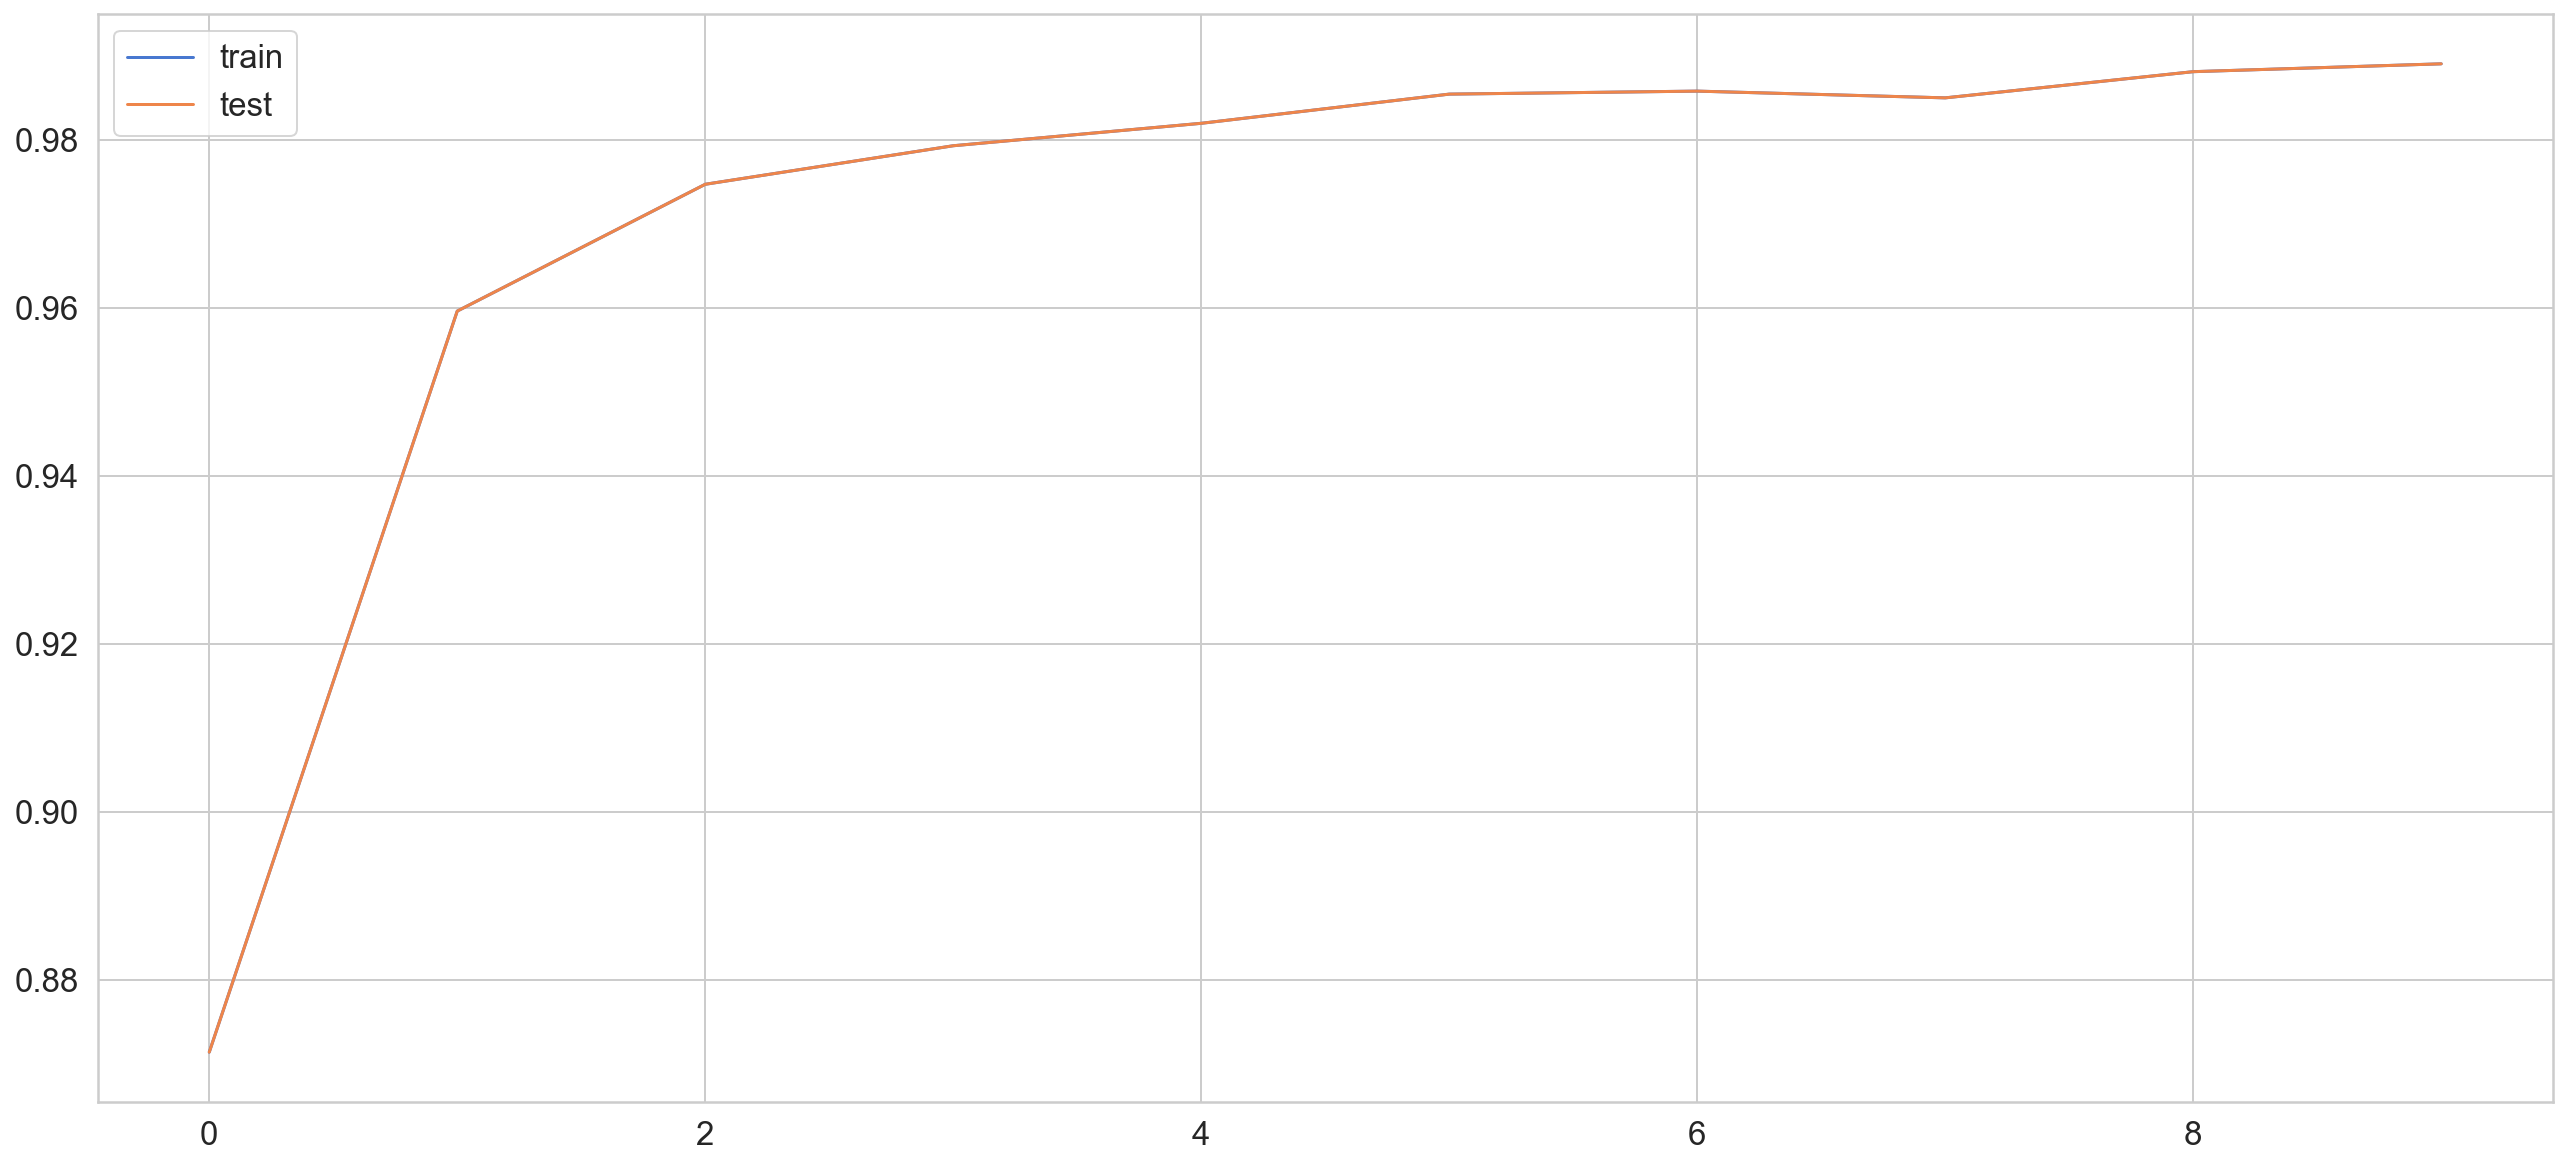

In [36]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['acc'], label='test')
plt.legend();

In [37]:
model.evaluate(X_test, y_test)

156/156 [==============================] - 11s 68ms/step - loss: 0.5211 - acc: 0.9054


[0.5210570693016052, 0.9054487347602844]

In [38]:
y_pred = model.predict(X_test)

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      # cmap=sns.diverging_palette(220, 20, n=7),
      cmap="coolwarm",
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

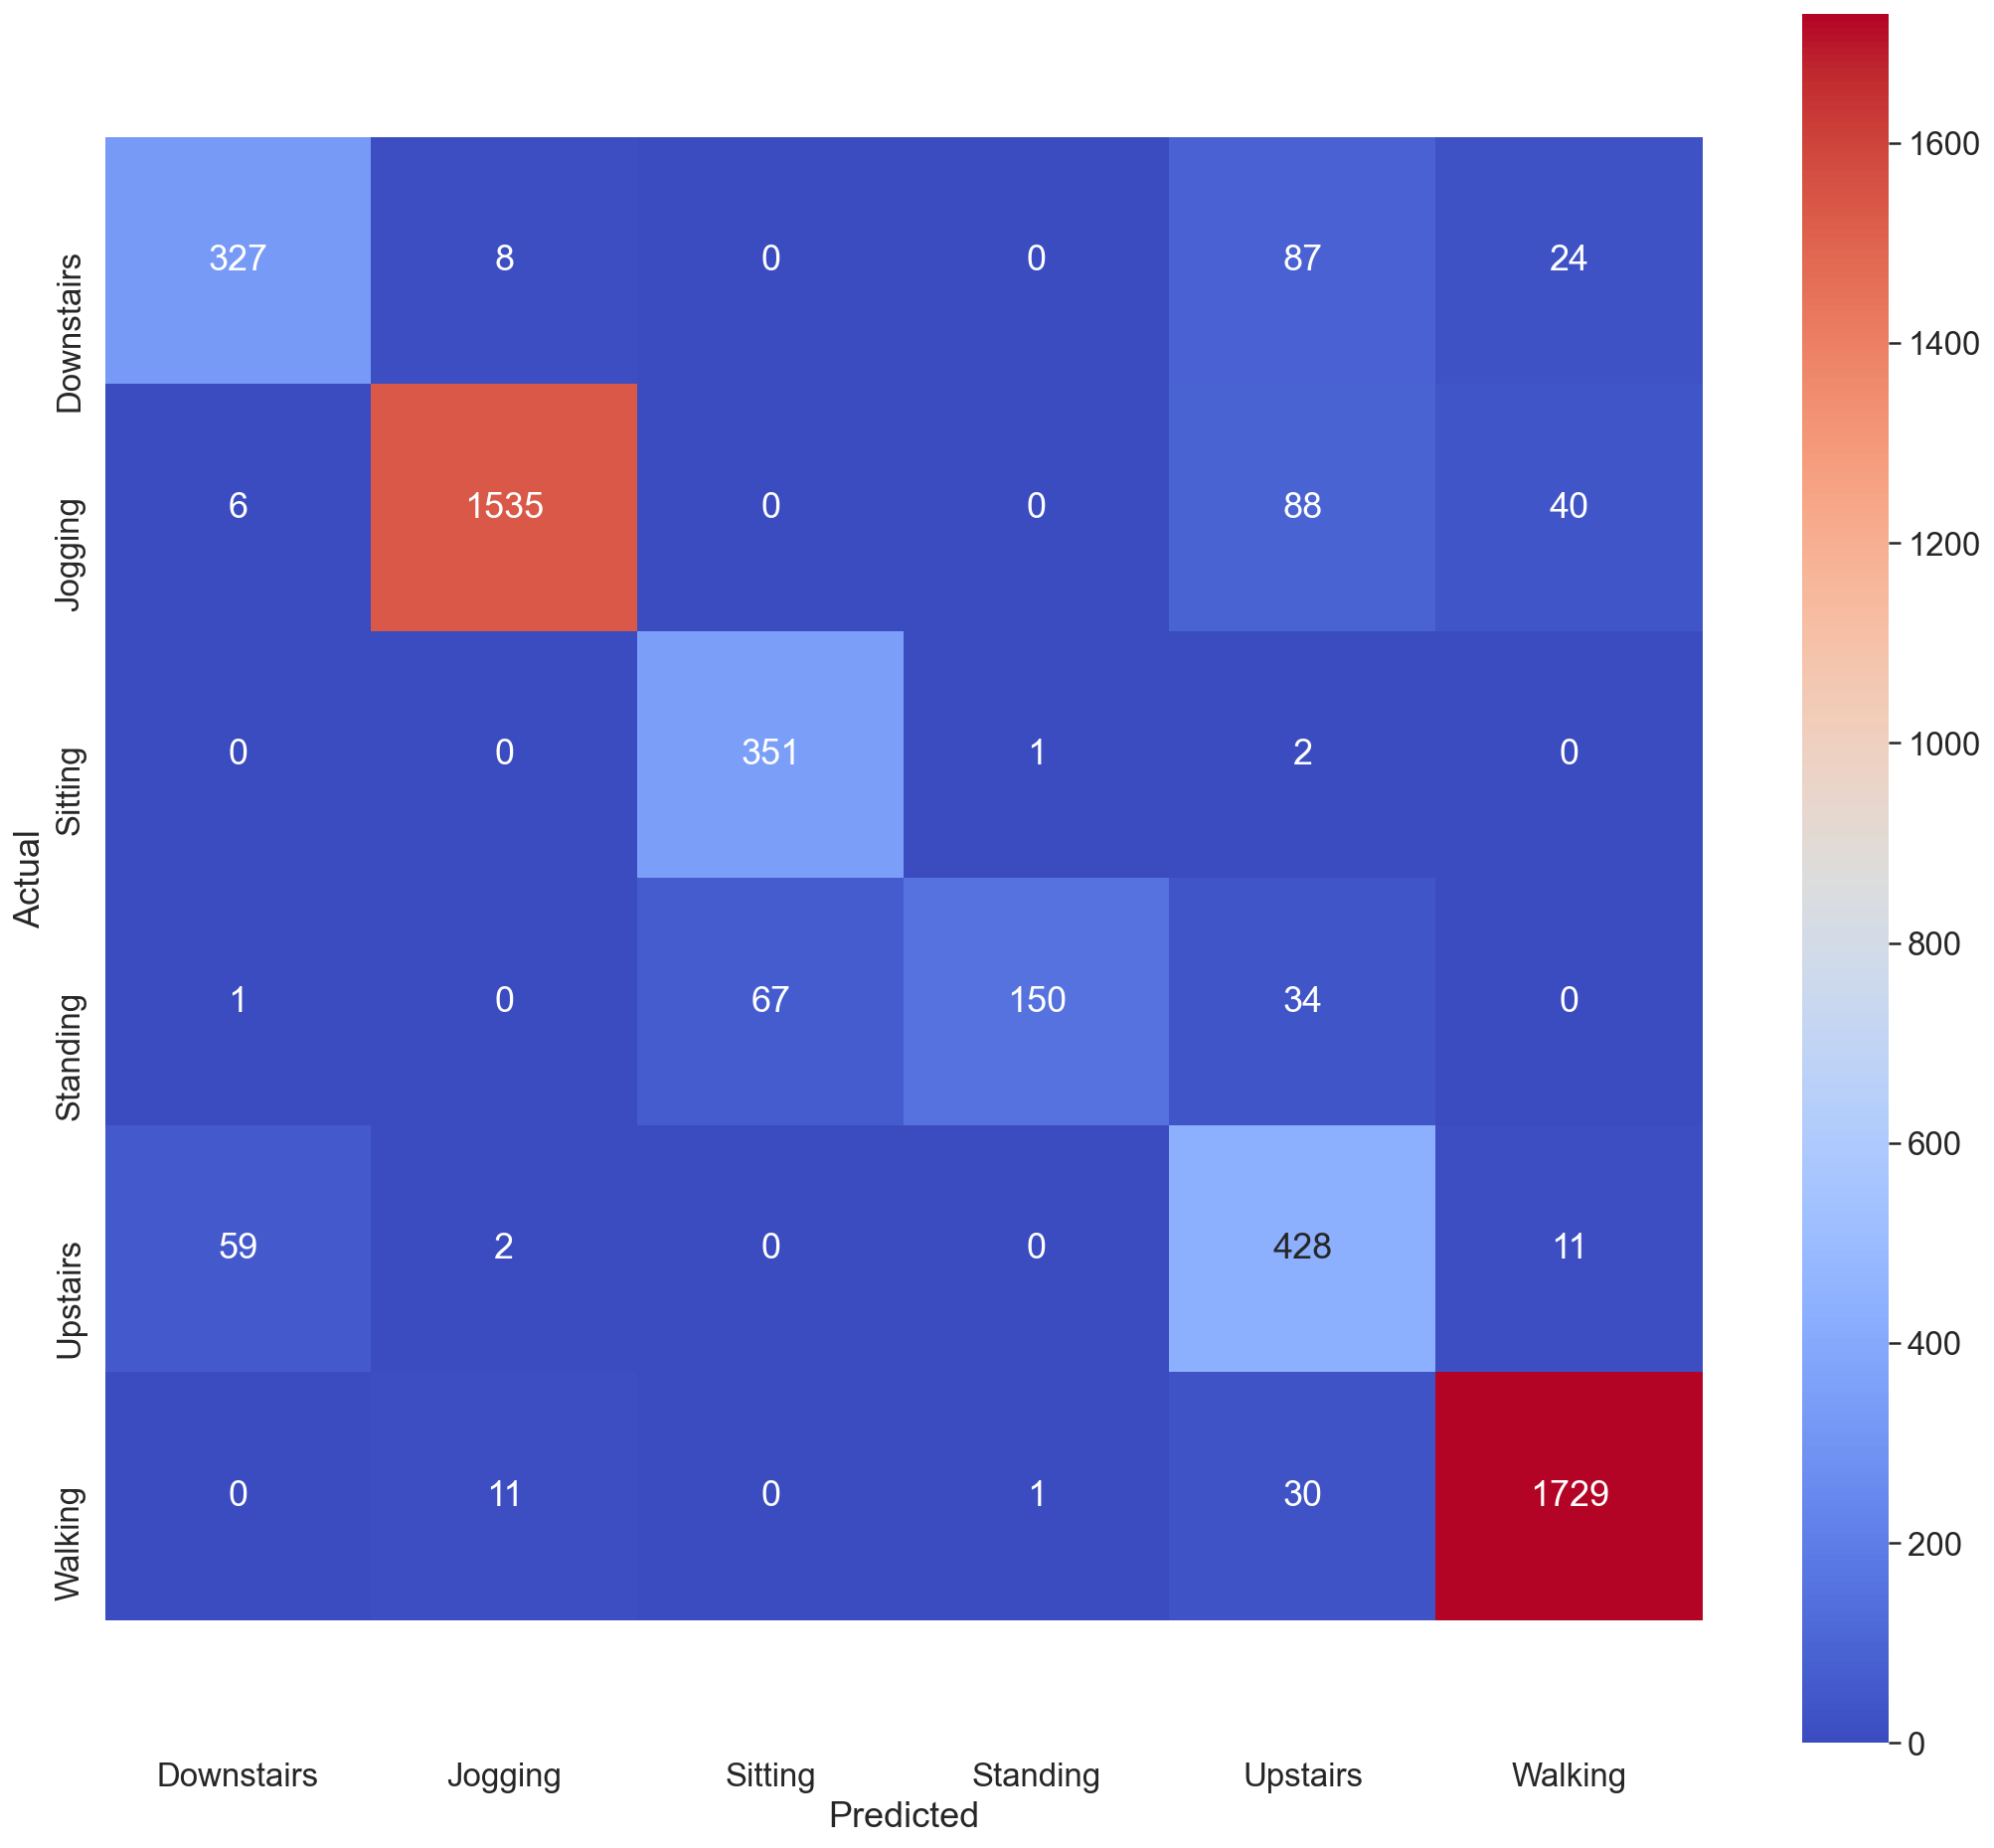

In [40]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

## Comparison to LSTM models and SOTA

## WISDM-2019

In [44]:
import os
import statistics
import csv
import itertools
from tensorflow import keras

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [45]:
act_path = "../data/wisdm-dataset/activity_key.txt"
act_file = open(act_path,"r")
act_list = act_file.read().split('\n')
act_map = {}
for elem in act_list:
    split = elem.split(" = ")
    if len(split) < 2:
        continue
    act_map[split[1]] = split[0]
    
act_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [83]:
act_map.values()

dict_values(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing', 'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich', 'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'])

In [51]:
import pickle

with open(r"../data/wisdm-dataset/phone.df", "rb") as input_file:
    phone = pickle.load(input_file)
    
with open(r"../data/wisdm-dataset/watch.df", "rb") as input_file:
    watch = pickle.load(input_file)

### Phone Data

In [52]:
window_size = 100
stride = window_size

frames = []
for i in tqdm(range(0, len(phone)-window_size, stride)):
    window = phone.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
        frames.append(window)

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [53]:
phone_set = set(phone['t'])
watch_set = set(watch['t'])

In [54]:
phone_set.intersection(watch_set)

set()

In [85]:
phone.head()

,participant,activity,t,phone_accel_x,phone_accel_y,phone_accel_z,phone_gyro_x,phone_gyro_y,phone_gyro_z
0,1631,D,1551056925666819,2.415741,8.470810,3.941772,-0.334335,-0.170898,0.175385
1,1631,D,1551056976020823,2.387329,7.766327,2.867630,-0.452133,0.375458,0.078552
2,1631,D,1551057026374827,8.274826,6.988464,1.375259,-0.982391,-0.198990,0.801300
3,1631,D,1551057076728831,4.721298,9.469116,5.418472,-0.643814,1.017700,-0.887161
4,1631,D,1551057127082835,1.159759,7.087219,3.427551,-1.286362,1.523544,-1.482986


In [76]:
phone.shape

(4780251, 9)

[[Text(0, 0, 'walking'),
  Text(1, 0, 'jogging'),
  Text(2, 0, 'stairs'),
  Text(3, 0, 'sitting'),
  Text(4, 0, 'standing'),
  Text(5, 0, 'typing'),
  Text(6, 0, 'teeth'),
  Text(7, 0, 'soup'),
  Text(8, 0, 'chips'),
  Text(9, 0, 'pasta'),
  Text(10, 0, 'drinking'),
  Text(11, 0, 'sandwich'),
  Text(12, 0, 'kicking'),
  Text(13, 0, 'catch'),
  Text(14, 0, 'dribbling'),
  Text(15, 0, 'writing'),
  Text(16, 0, 'clapping'),
  Text(17, 0, 'folding')]]

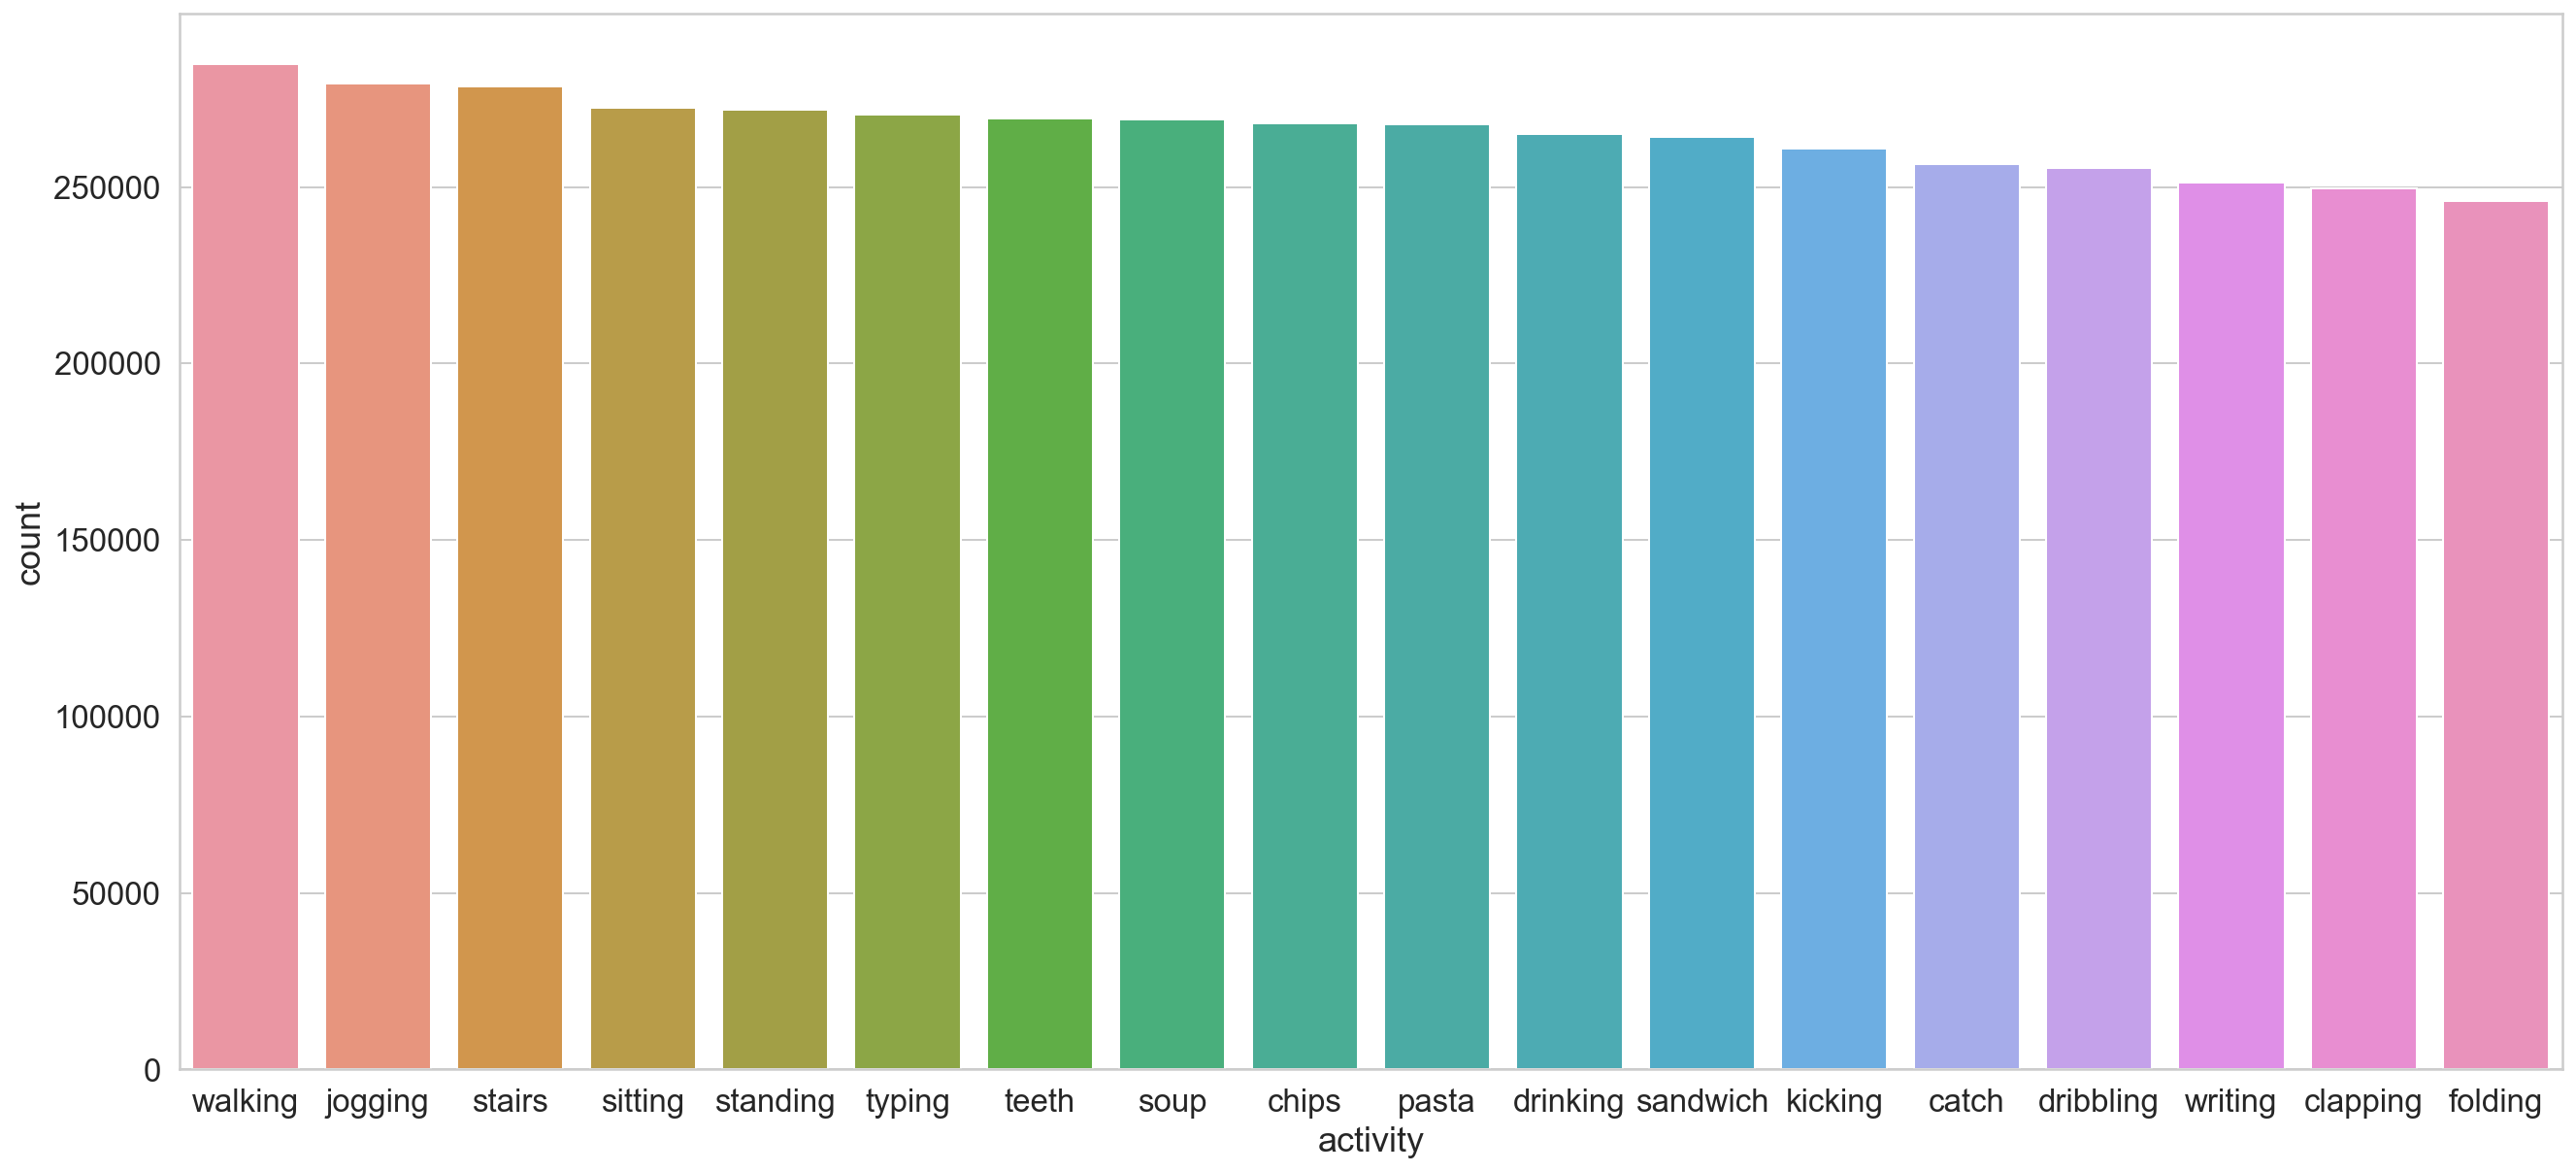

In [84]:
cp = sns.countplot(x = 'activity',
              data = phone,
              order = phone.activity.value_counts().index);
cp.set(xticklabels=act_map.values())

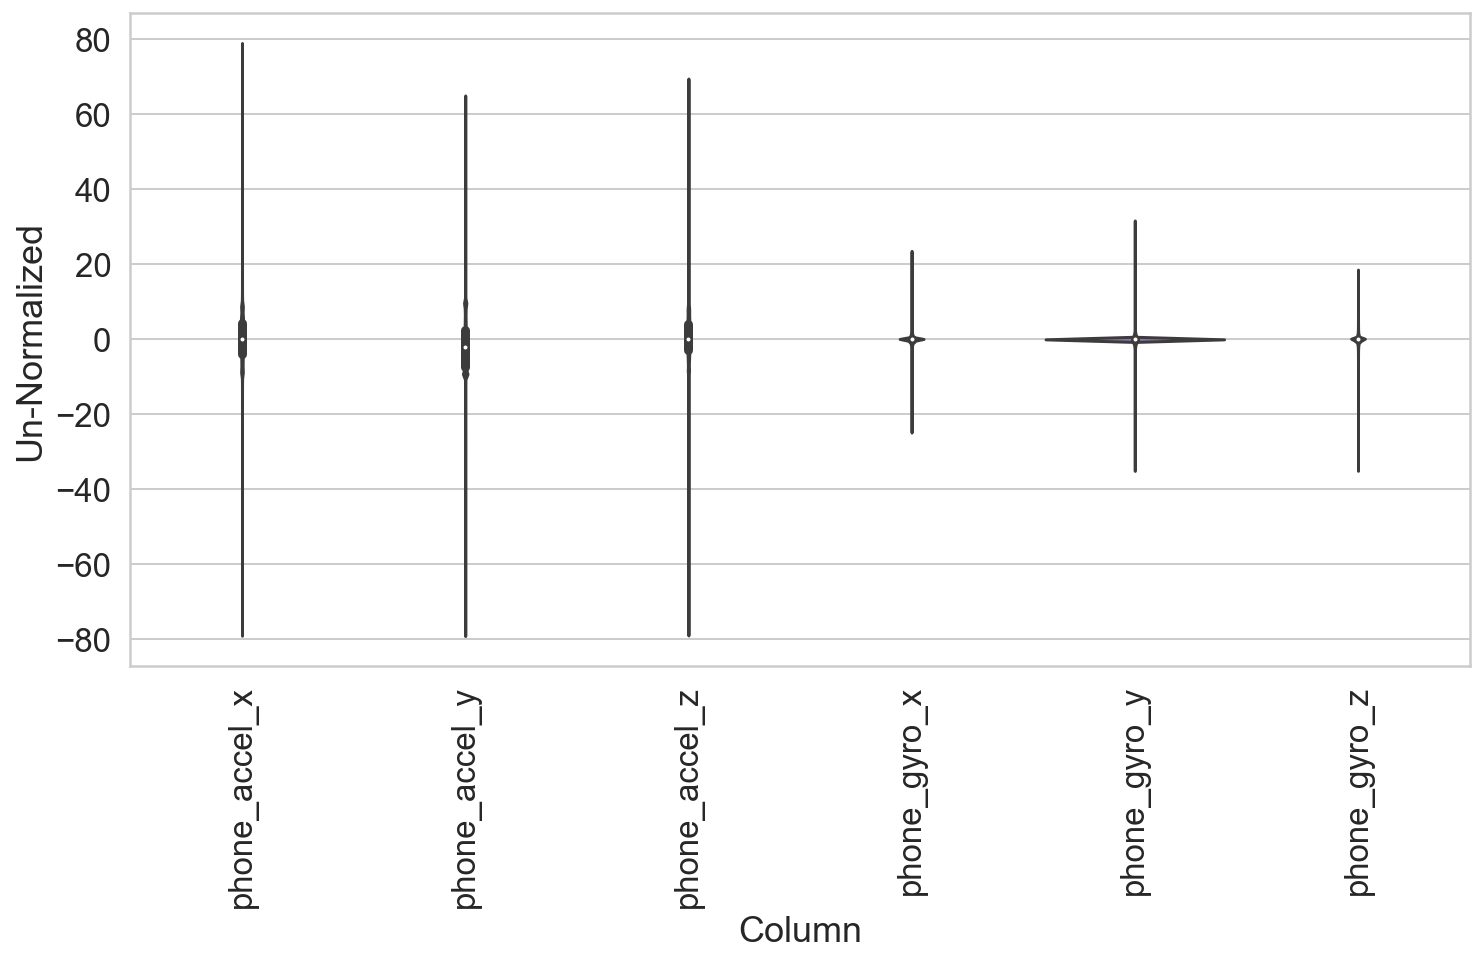

In [75]:
df_dist = phone[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].melt(var_name='Column', value_name='Un-Normalized')

df_dist.dropna(inplace=True)
df_dist = df_dist.astype({'Un-Normalized': 'float'})

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Un-Normalized', data=df_dist)
_ = ax.set_xticklabels(phone[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].keys(), rotation=90)

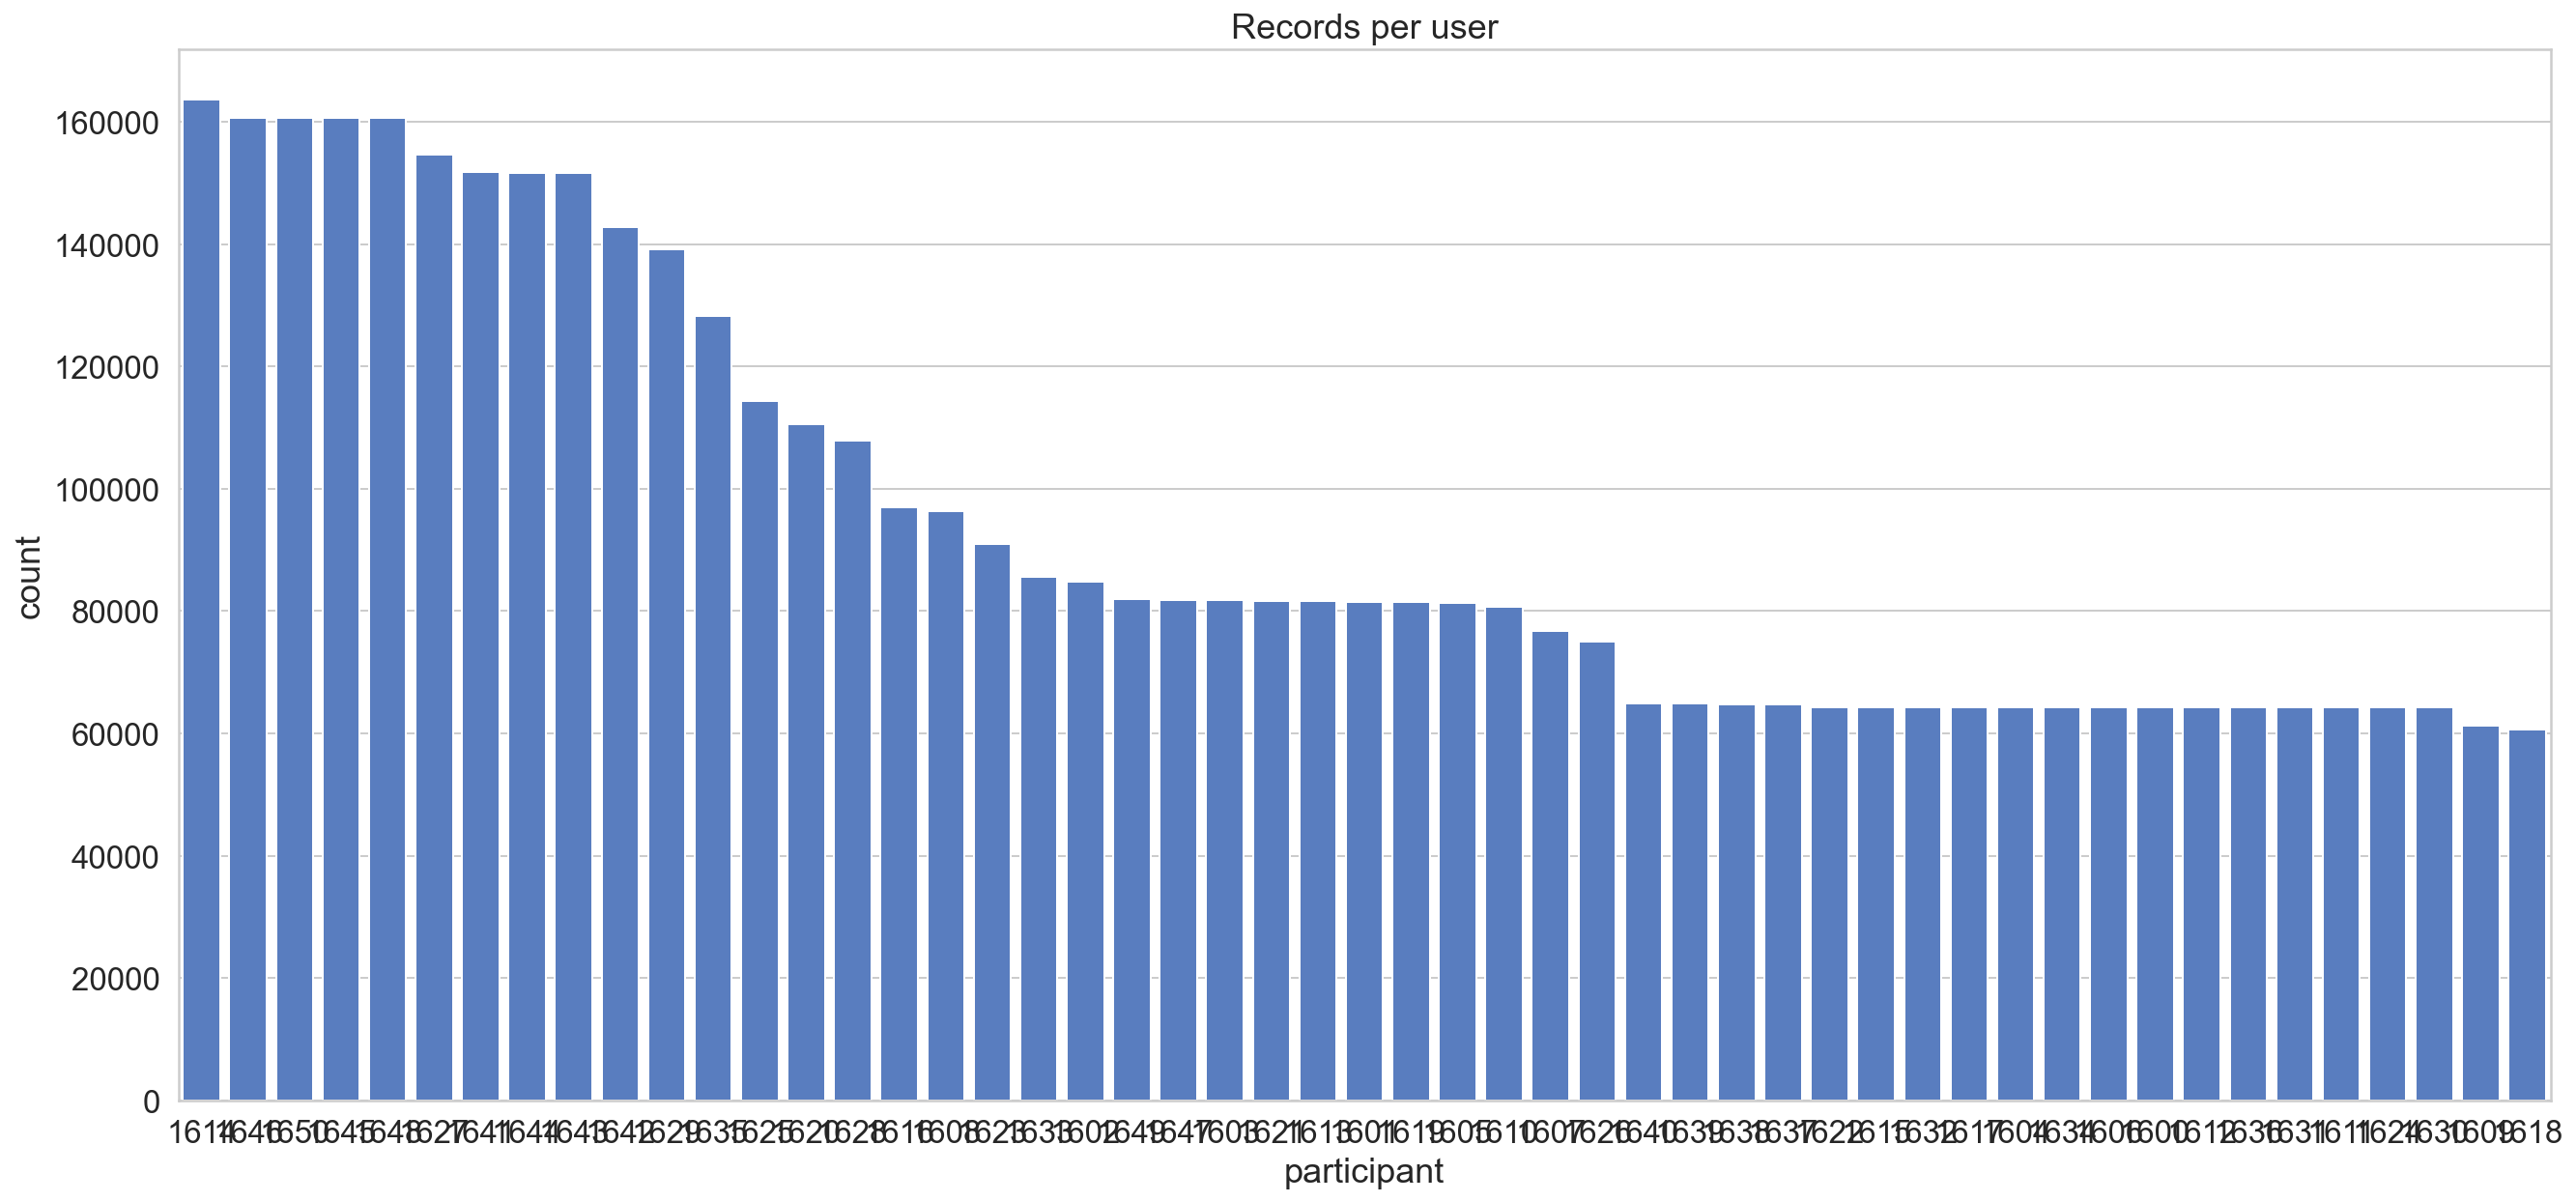

In [87]:
sns.countplot(x = 'participant',
              data = phone,
              palette=[sns.color_palette()[0]],
              order = phone.participant.value_counts().index);
plt.title("Records per user");

In [92]:
phone_feats = phone[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']]
column_indices = {name: i for i, name in enumerate(phone_feats.columns)}

n = len(phone)
train_df = phone[0:int(n*0.7)]
val_df = phone[int(n*0.7):int(n*0.9)]
test_df = phone[int(n*0.9):]

num_features = phone_feats.shape[1]
num_features

6

In [94]:
train_df.head()

,participant,activity,t,phone_accel_x,phone_accel_y,phone_accel_z,phone_gyro_x,phone_gyro_y,phone_gyro_z
0,1631,D,1551056925666819,2.415741,8.470810,3.941772,-0.334335,-0.170898,0.175385
1,1631,D,1551056976020823,2.387329,7.766327,2.867630,-0.452133,0.375458,0.078552
2,1631,D,1551057026374827,8.274826,6.988464,1.375259,-0.982391,-0.198990,0.801300
3,1631,D,1551057076728831,4.721298,9.469116,5.418472,-0.643814,1.017700,-0.887161
4,1631,D,1551057127082835,1.159759,7.087219,3.427551,-1.286362,1.523544,-1.482986


In [105]:
def plot_activity_2019(activity, df):
    data = df[df['activity'] == activity][['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']][:400]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

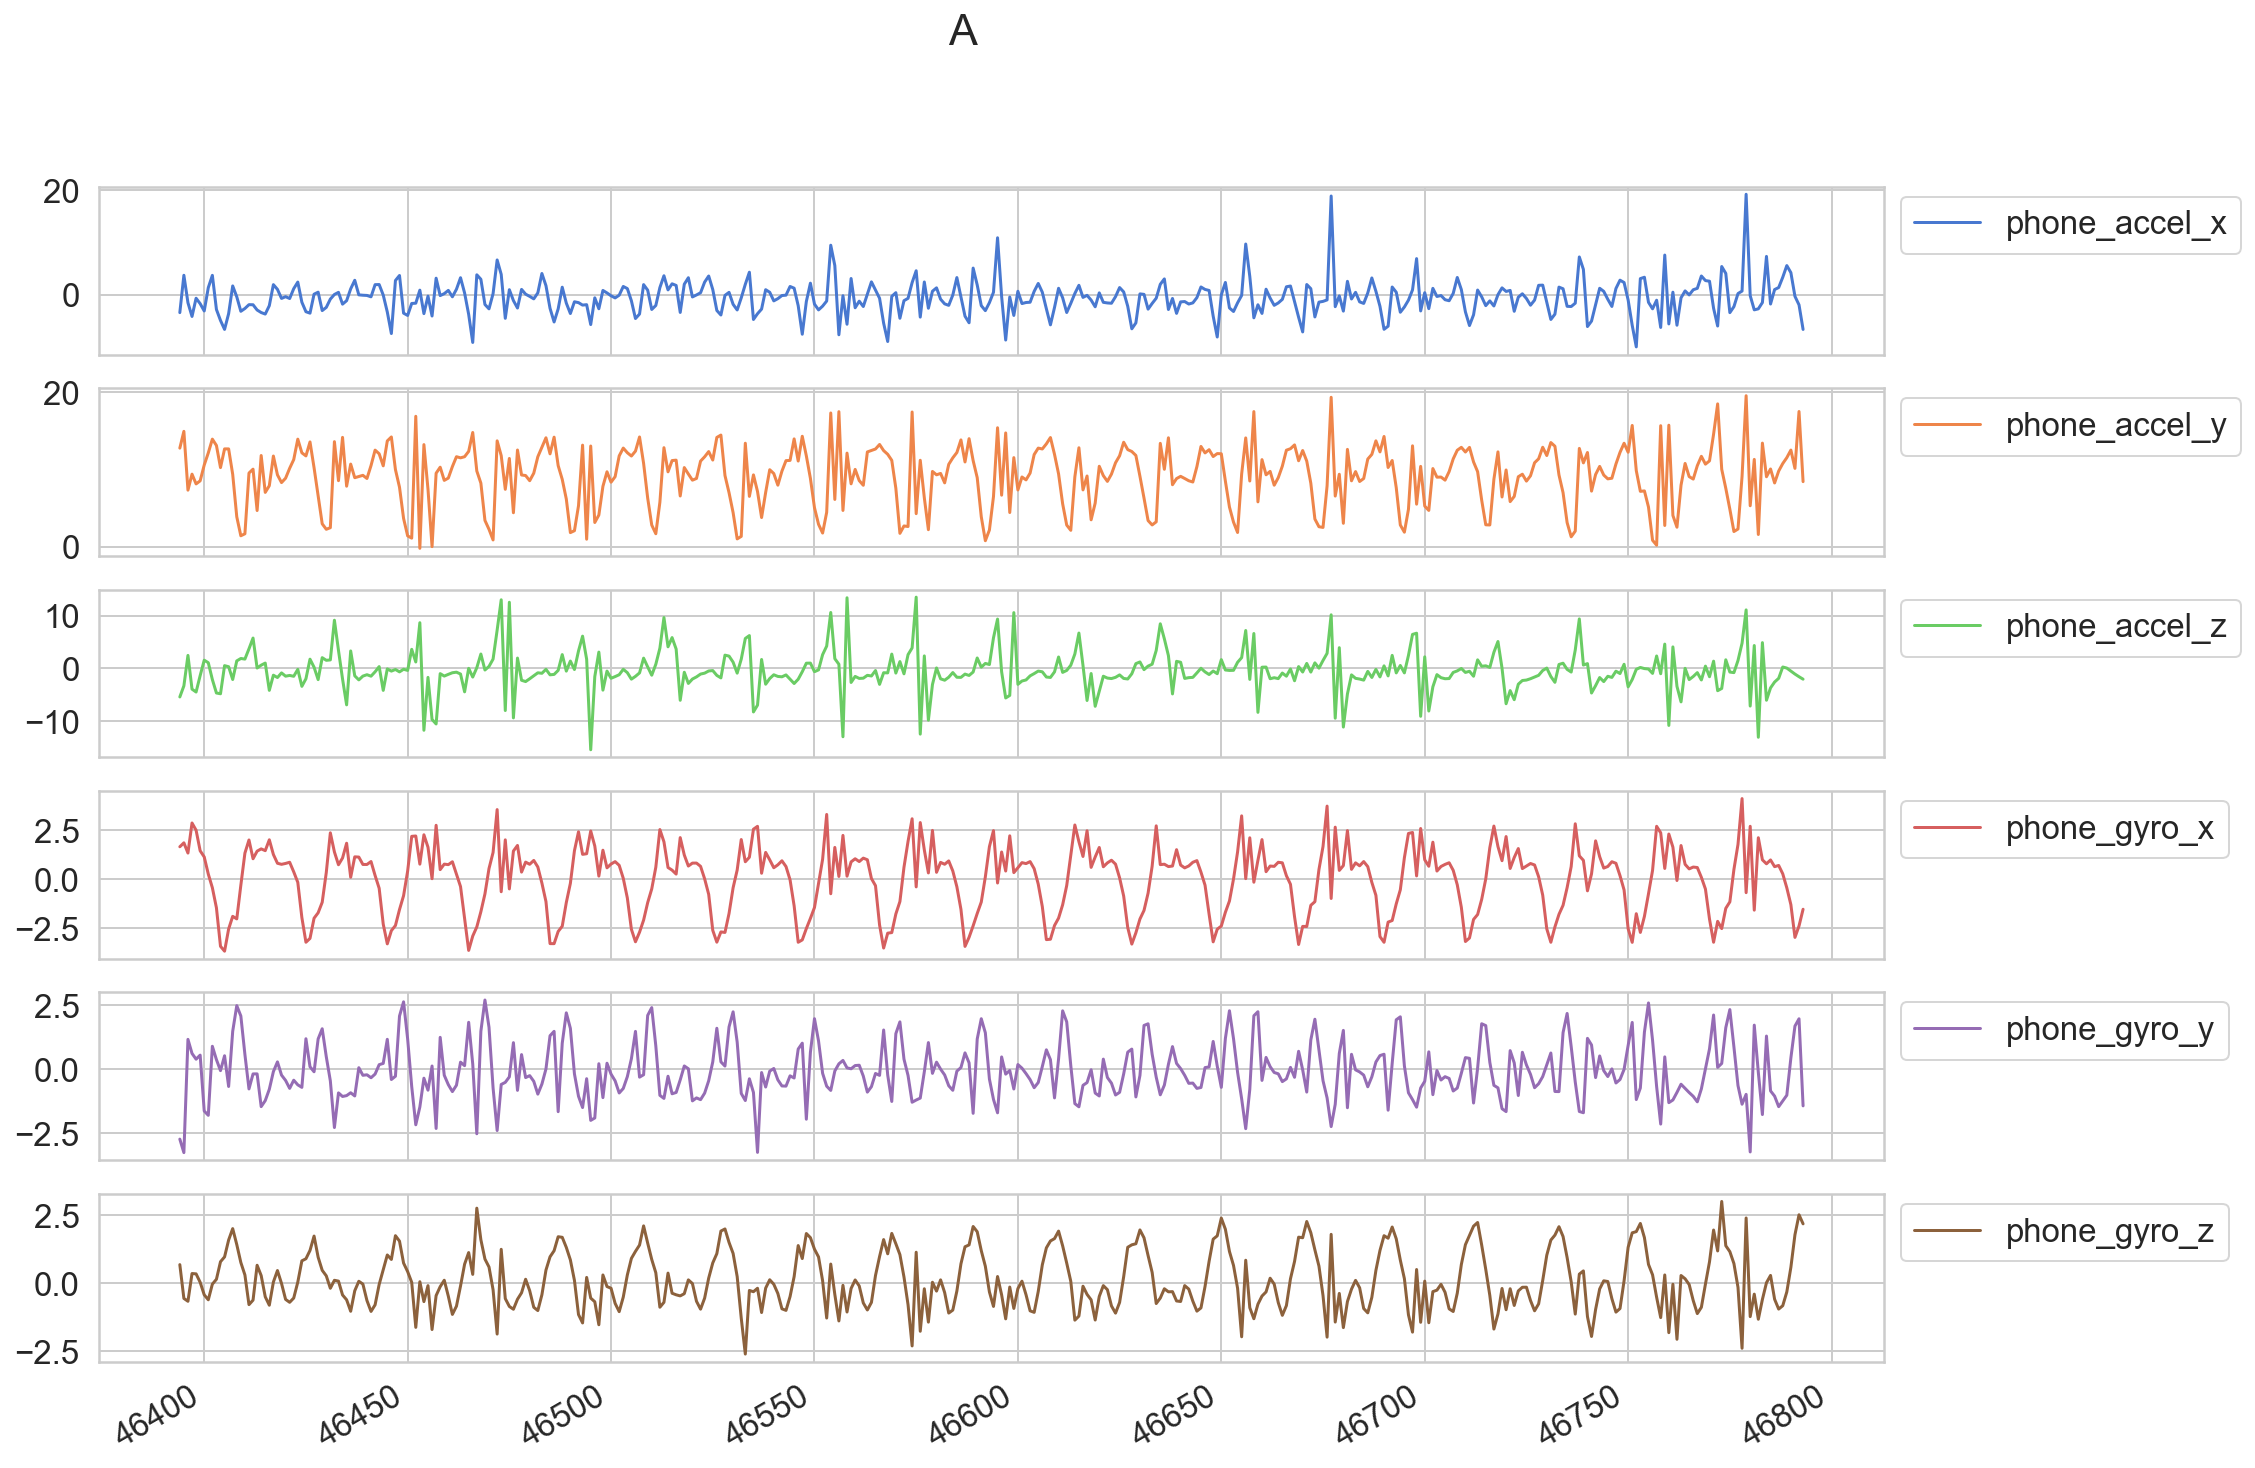

In [107]:
plot_activity_2019("A", train_df);

In [55]:
activities = sorted(act_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

for frame in tqdm(frames):
    X_list.append(frame[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [108]:
df_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.019955,0.252293,-0.090959
8490,17,Walking,57870012316000,-0.055118,0.297966,-0.099228
8491,17,Walking,57870122301000,-0.085505,0.257187,-0.124035
8492,17,Walking,57870222246000,-0.035456,0.284917,-0.085446
8493,17,Walking,57870332292000,-0.035456,0.293073,-0.107497


In [117]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']

scaler = RobustScaler()

scaler = scaler.fit(train_df[scale_columns])

train_df.loc[:, scale_columns] = scaler.transform(train_df[scale_columns].to_numpy())
test_df.loc[:, scale_columns] = scaler.transform(test_df[scale_columns].to_numpy())

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [135]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    train_df[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']], 
    train_df.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    test_df[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']], 
    test_df.activity, 
    TIME_STEPS, 
    STEP
)

In [136]:
print(X_train.shape, y_train.shape)

(83650, 200, 3) (83650, 1)


In [137]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [138]:
print(X_train.shape, y_train.shape)

(83650, 200, 3) (83650, 18)


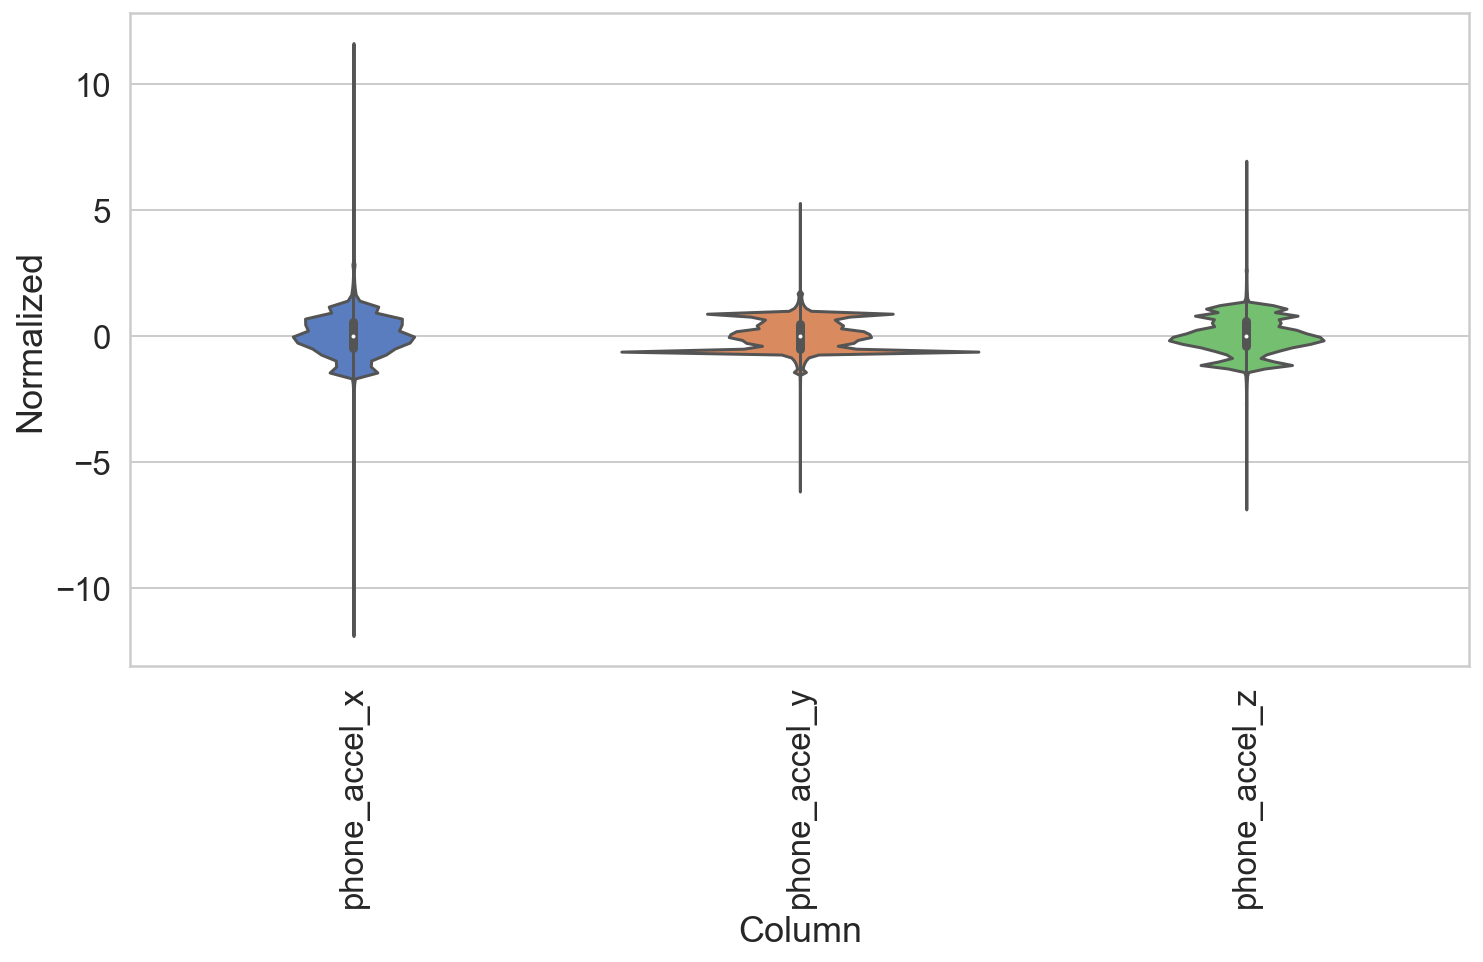

In [139]:
df_dist = train_df[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']].melt(var_name='Column', value_name='Normalized')

df_dist.dropna(inplace=True)
df_dist = df_dist.astype({'Normalized': 'float'})

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_dist)
_ = ax.set_xticklabels(phone[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']].keys(), rotation=90)

In [140]:
# X = np.array(X_list)
# y = np.array(to_categorical(y_list))

In [141]:
# print(X.shape)
# print(y.shape)

In [142]:
# n = 1000
# pd.DataFrame(X_list[n]).plot()

# reverse_activity_encoding = {v: act_map[k] for k, v in activity_encoding.items()}
# print(reverse_activity_encoding[y_list[n]])

In [144]:
# X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_val.shape)
# print(y_test.shape)

In [145]:
model = keras.Sequential()

#model.add(layers.Dense(units=128))
model.add(layers.Convolution1D(filters=128, kernel_size=16, activation='relu'))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(18, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [146]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test)
)

Epoch 1/50
880/880 [==============================] - 63s 71ms/step - loss: 2.3740 - acc: 0.1905 - val_loss: 2.0321 - val_acc: 0.2672
Epoch 2/50
880/880 [==============================] - 57s 65ms/step - loss: 2.0350 - acc: 0.2649 - val_loss: 1.9494 - val_acc: 0.2987
Epoch 3/50
880/880 [==============================] - 60s 68ms/step - loss: 1.9344 - acc: 0.3066 - val_loss: 1.8623 - val_acc: 0.3445
Epoch 4/50
880/880 [==============================] - 59s 67ms/step - loss: 1.8544 - acc: 0.3370 - val_loss: 1.7885 - val_acc: 0.3620
Epoch 5/50
880/880 [==============================] - 60s 68ms/step - loss: 1.8100 - acc: 0.3574 - val_loss: 1.7482 - val_acc: 0.3807
Epoch 6/50
880/880 [==============================] - 61s 69ms/step - loss: 1.7683 - acc: 0.3681 - val_loss: 1.7334 - val_acc: 0.3848
Epoch 7/50
880/880 [==============================] - 63s 71ms/step - loss: 1.7402 - acc: 0.3807 - val_loss: 1.7074 - val_acc: 0.4124
Epoch 8/50
880/880 [==============================] - 62s 71ms

In [132]:
# model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

In [147]:
# y_val_pred = model.predict(X_val)

# y_val_argmax = y_val.argmax(axis=1)
# y_val_pred_argmax = y_val_pred.argmax(axis=1)

# actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
# predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

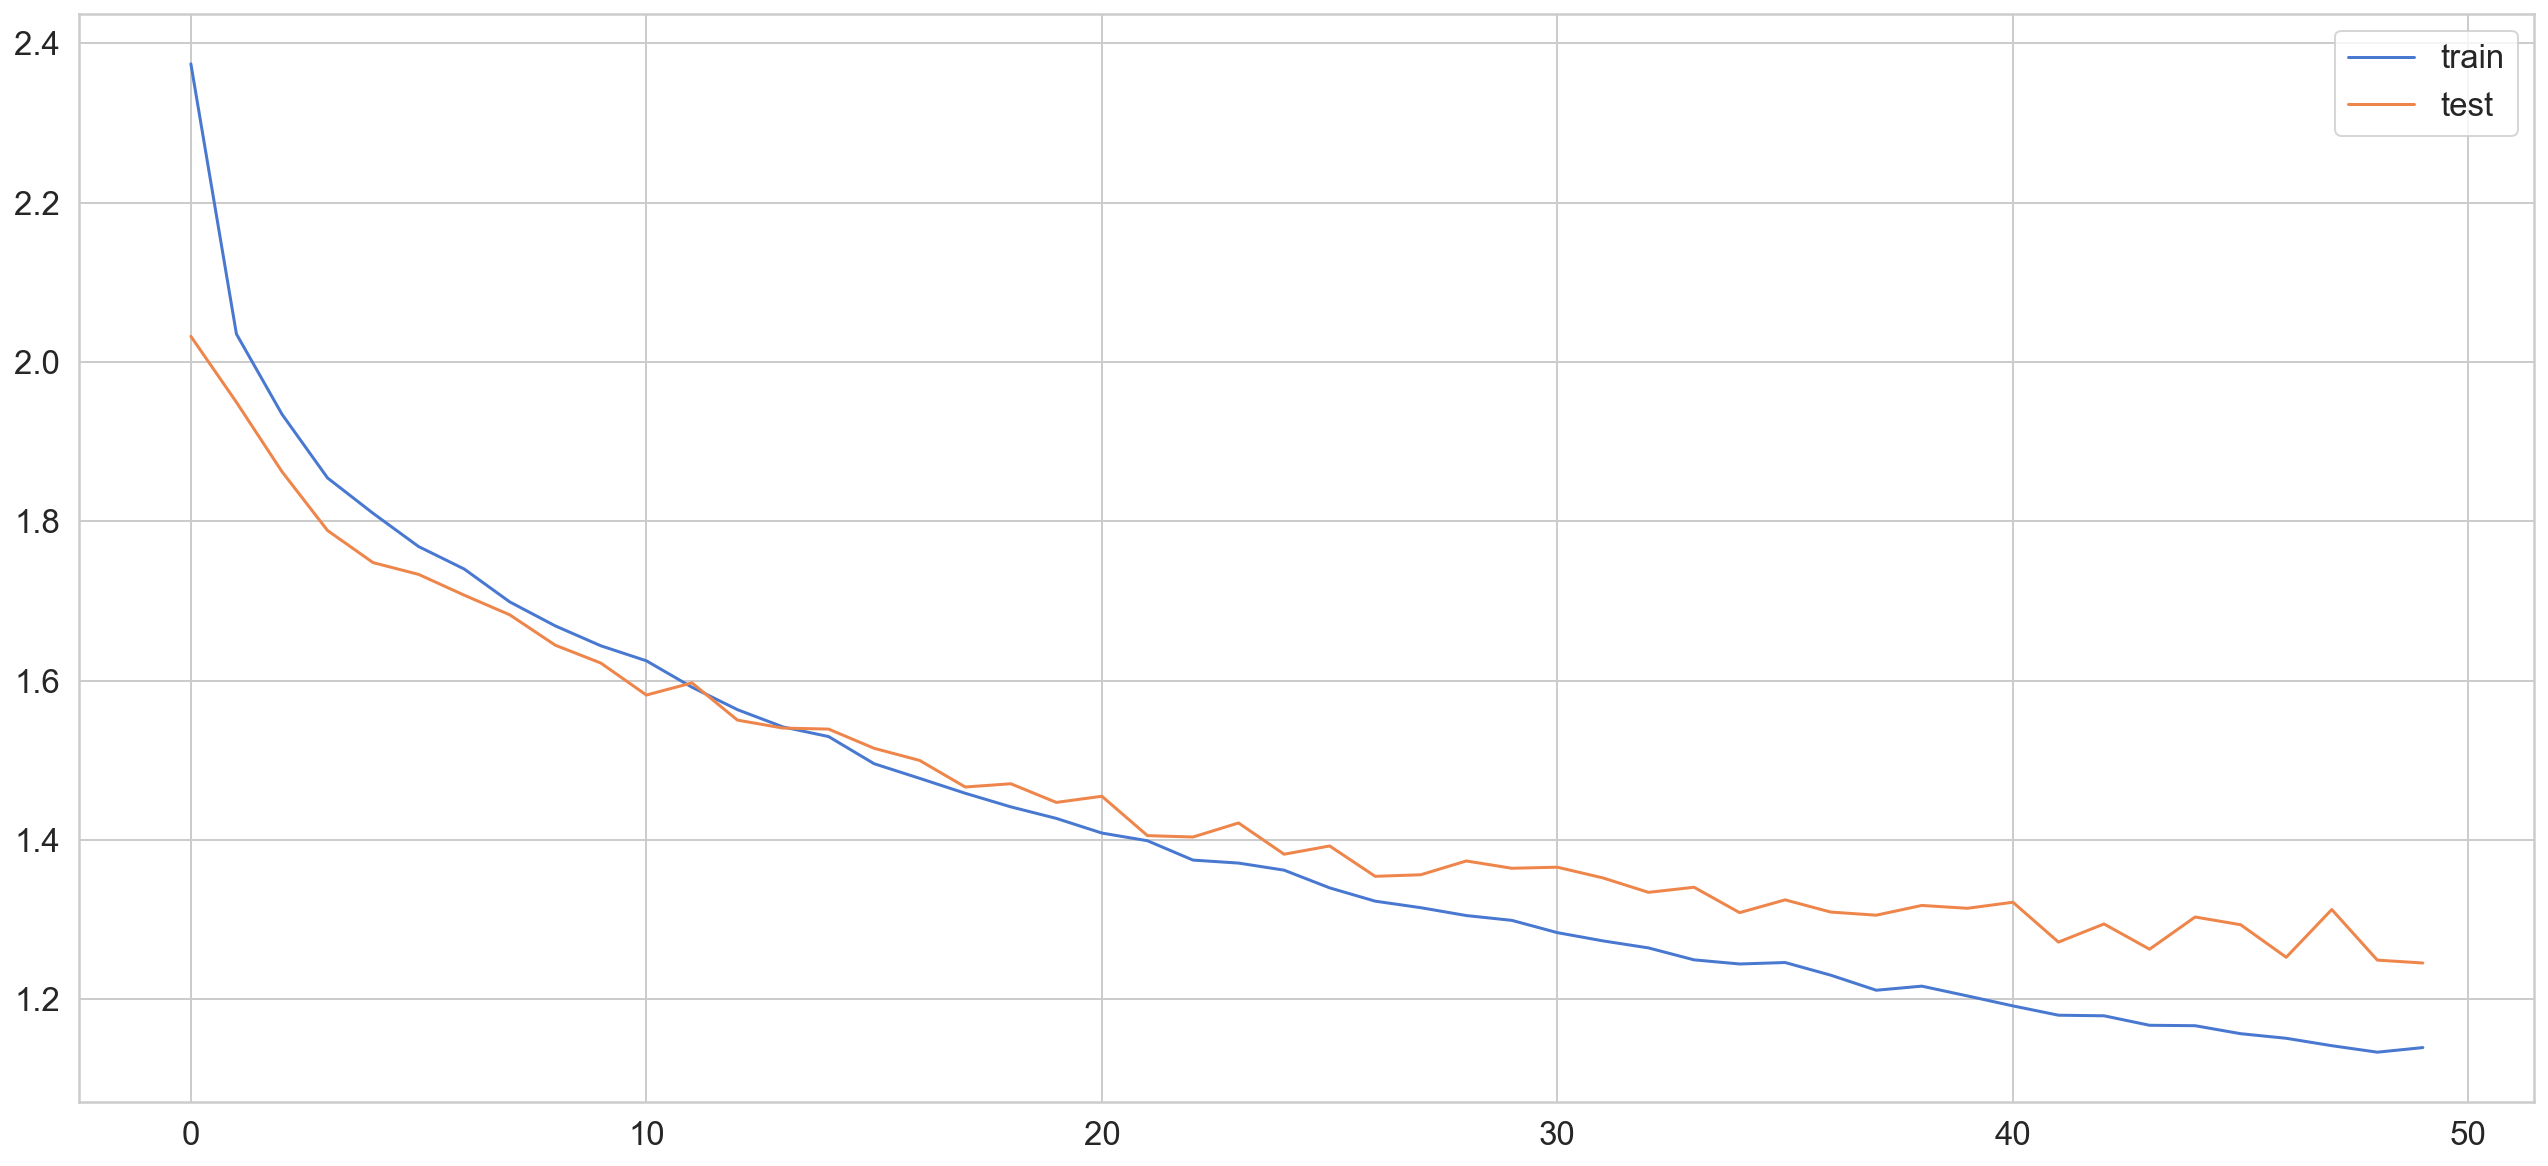

In [149]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

<AxesSubplot:>

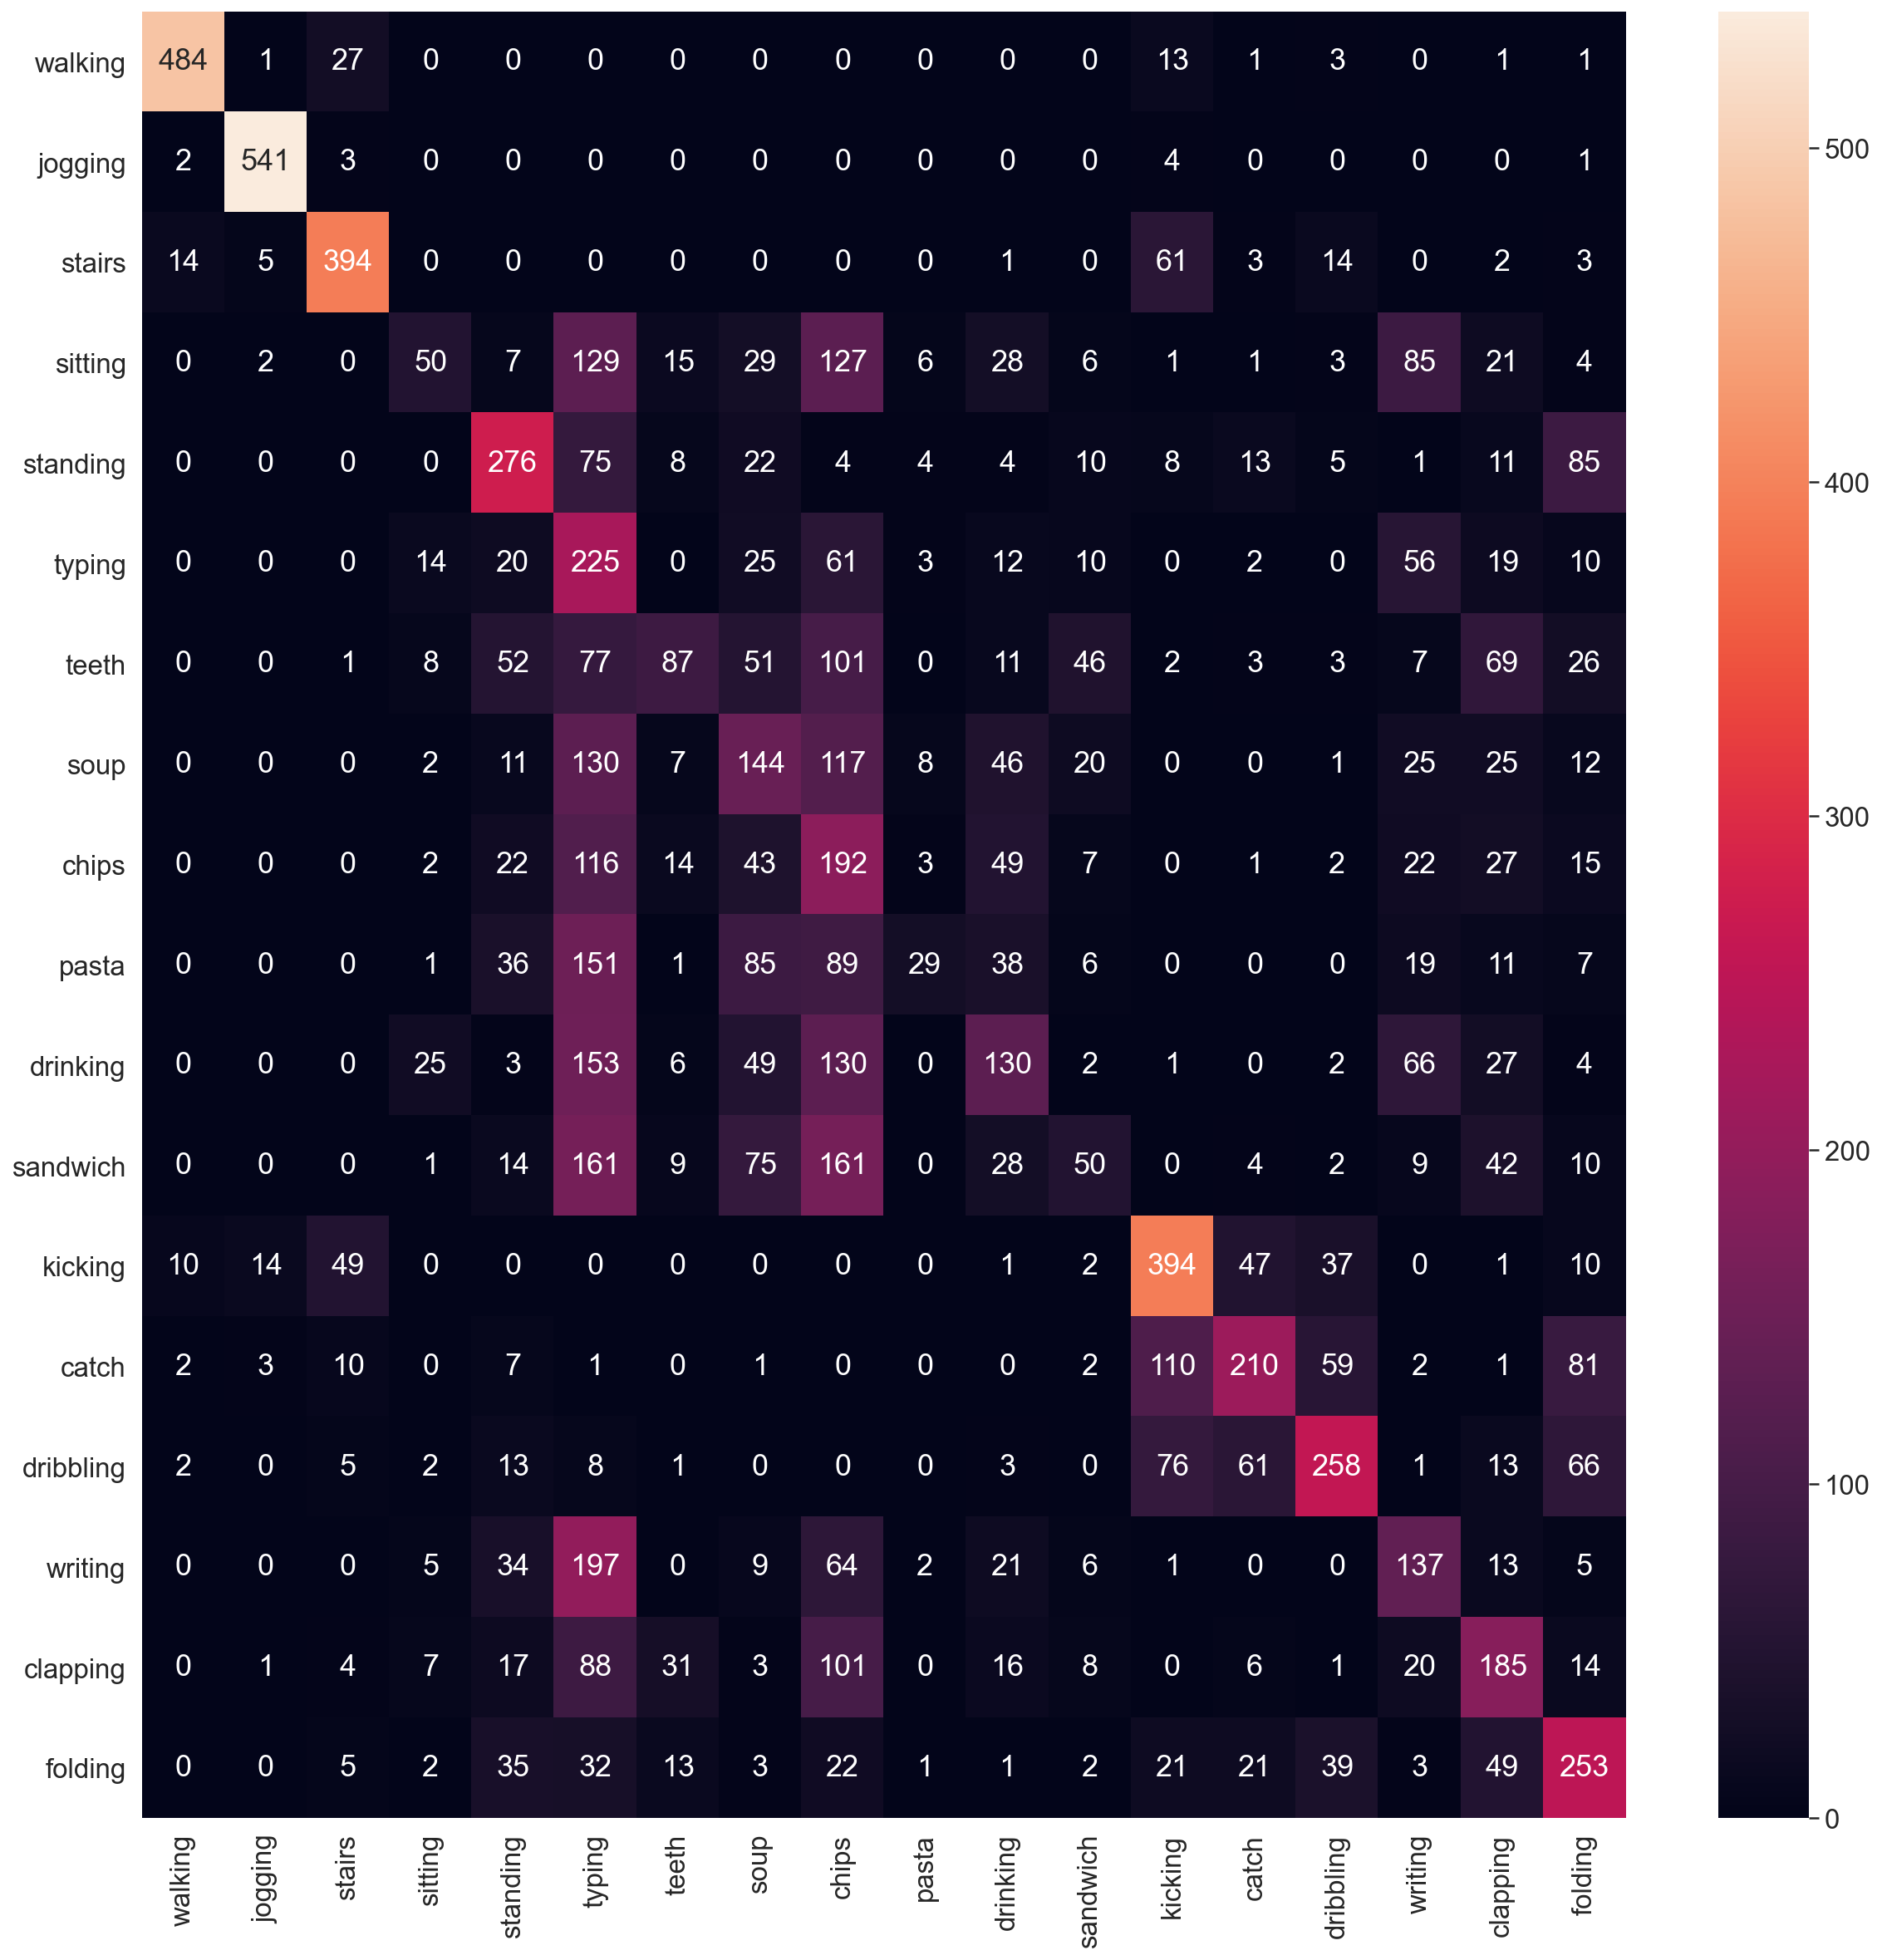

In [148]:
cm = confusion_matrix(y_val_argmax, y_val_pred_argmax)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True, fmt='g')